In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)
import os
import seaborn as sns

from scipy.fft import fft, ifft
from scipy.stats import gaussian_kde, ttest_ind, entropy, ks_2samp

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, GRU, Input, Activation, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils import plot_model

import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_excel('50 throttle not enough power(annotated).xlsx')
df.head()

Time (s)  Motor Speed (RPM)  Engine Speed (RPM)  Throttle (%)  \
0      4.04                0.0                   0             5   
1      4.30                0.0                   0             5   
2      4.54                0.0                   0             5   
3      4.80                0.0                   0             5   
4      5.04                0.0                   0             5   

   Intake Temperature (C)  Engine Coolant Temperature 1 (C)  \
0                      37                                26   
1                      37                                26   
2                      37                                26   
3                      37                                26   
4                      37                                26   

   Engine Coolant Temperature 2 (C)  Barometric Pressure (kpa)  Fuel Trim  \
0                                27                        100        0.0   
1                                27                        100        0.0   
2                                27                        100        0.0   
3                                27                        100        0.0   
4                                27                        100        0.0   

   Fuel Consumption (g/min)  Fuel Consumed (g)  Expected BSFC (g/kW.hr)  \
0                       0.0                  0                        0   
1                       0.0                  0                        0   
2                       0.0                  0                        0   
3                       0.0                  0                        0   
4                       0.0                  0                        0   

   Actual BSFC (g/kW.hr)  Expected Max Power (W)  Bus Voltage (V)  \
0                      0                       0            50.14   
1                      0                       0            50.14   
2                      0                       0            50.14   
3                      0                       0            50.14   
4                      0                       0            50.14   

   GCU Current (A)  Battery Current (A)  Power Generated (W)  \
0              0.4                 0.36                   22   
1              0.4                 0.39                   21   
2              0.4                 0.39                   22   
3              0.4                 0.40                   21   
4              0.4                 0.41                   21   

   GCU Phase Current (A)  Inverter Temperature (C)  \
0                    0.0                        23   
1                    0.0                        23   
2                    0.0                        23   
3                    0.0                        23   
4                    0.0                        23   

   Target Fuel Pressure (bar)  Fuel Pressure (bar)  Fuel Pump Speed (RPM)  \
0                         3.1                  3.0                      0   
1                         3.1                  3.0                      2   
2                         3.1                  3.0                      0   
3                         3.1                  3.0                      3   
4                         3.1                  3.0                      0   

   Cooling Pump Speed (RPM)   Fans On (qty)   PWM Uptime (s)  
0                      2200               0                4  
1                      2489               0                5  
2                      2670               0                5  
3                      2907               0                5  
4                      3096               0                5

In [3]:
df.shape

(10466, 26)

In [4]:
reference_date = pd.to_datetime('1970-01-01')
df['Time (s)'] = reference_date + pd.to_timedelta(df['Time (s)'], unit='s')
df['Time (s)'].dtype

dtype('<M8[ns]')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10466 entries, 0 to 10465
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Time (s)                          10466 non-null  datetime64[ns]
 1   Motor Speed (RPM)                 10466 non-null  float64       
 2   Engine Speed (RPM)                10466 non-null  int64         
 3   Throttle (%)                      10466 non-null  int64         
 4   Intake Temperature (C)            10466 non-null  int64         
 5   Engine Coolant Temperature 1 (C)  10466 non-null  int64         
 6   Engine Coolant Temperature 2 (C)  10466 non-null  int64         
 7   Barometric Pressure (kpa)         10466 non-null  int64         
 8   Fuel Trim                         10466 non-null  float64       
 9   Fuel Consumption (g/min)          10466 non-null  float64       
 10  Fuel Consumed (g)                 10466 non-nu

In [6]:
df.describe()

Time (s)  Motor Speed (RPM)  Engine Speed (RPM)  \
count                          10466       10466.000000        10466.000000   
mean   1970-01-01 00:21:52.165119434        4406.881626         4411.613415   
min       1970-01-01 00:00:04.040000          -0.900000            0.000000   
25%       1970-01-01 00:10:58.102500           0.000000            0.000000   
50%       1970-01-01 00:21:52.165000        4323.350000         4344.000000   
75%       1970-01-01 00:32:46.227500        8254.850000         8192.000000   
max       1970-01-01 00:43:40.290000        8601.400000         8192.000000   
std                              NaN        3820.877719         3735.061259   

       Throttle (%)  Intake Temperature (C)  Engine Coolant Temperature 1 (C)  \
count  10466.000000            10466.000000                      10466.000000   
mean      37.451175               47.456430                         60.074336   
min        5.000000               36.000000                         26.000000   
25%        5.000000               37.000000                         29.000000   
50%       46.000000               50.000000                         62.000000   
75%       60.000000               57.000000                         87.000000   
max      100.000000               60.000000                         94.000000   
std       27.745464                9.439204                         26.885527   

       Engine Coolant Temperature 2 (C)  Barometric Pressure (kpa)  \
count                      10466.000000               10466.000000   
mean                          59.455284                  99.850850   
min                           27.000000                  98.000000   
25%                           29.000000                 100.000000   
50%                           65.000000                 100.000000   
75%                           85.000000                 100.000000   
max                           90.000000                 100.000000   
std                           25.909670                   0.373792   

          Fuel Trim  Fuel Consumption (g/min)  ...  Battery Current (A)  \
count  10466.000000              10466.000000  ...         10466.000000   
mean       0.795927                 16.430566  ...             1.196864   
min        0.000000                 -0.200000  ...           -31.450000   
25%        0.000000                  0.000000  ...            -0.027500   
50%        1.000000                 21.600000  ...             0.600000   
75%        1.370000                 27.700000  ...             1.260000   
max        1.590000                 51.400000  ...            89.380000   
std        0.603548                 13.781272  ...             5.877447   

       Power Generated (W)  GCU Phase Current (A)  Inverter Temperature (C)  \
count         10466.000000           10466.000000              10466.000000   
mean           1488.168737             -24.480179                 44.824479   
min           -1226.000000             -66.090000                 23.000000   
25%              14.000000             -51.037500                 33.000000   
50%             190.000000              -9.670000                 44.000000   
75%            3189.000000               0.000000                 57.000000   
max            4098.000000              15.040000                 61.000000   
std            1577.405594              24.931087                 12.269176   

       Target Fuel Pressure (bar)  Fuel Pressure (bar)  Fuel Pump Speed (RPM)  \
count                10466.000000         10466.000000           10466.000000   
mean                     3.092117             2.915756            1270.082362   
min                      1.000000             0.100000               0.000000   
25%                      3.100000             2.700000               0.000000   
50%                      3.100000             3.100000            1910.000000   
75%                      3.100000             3.100000            2096.000000   


<Axes: >

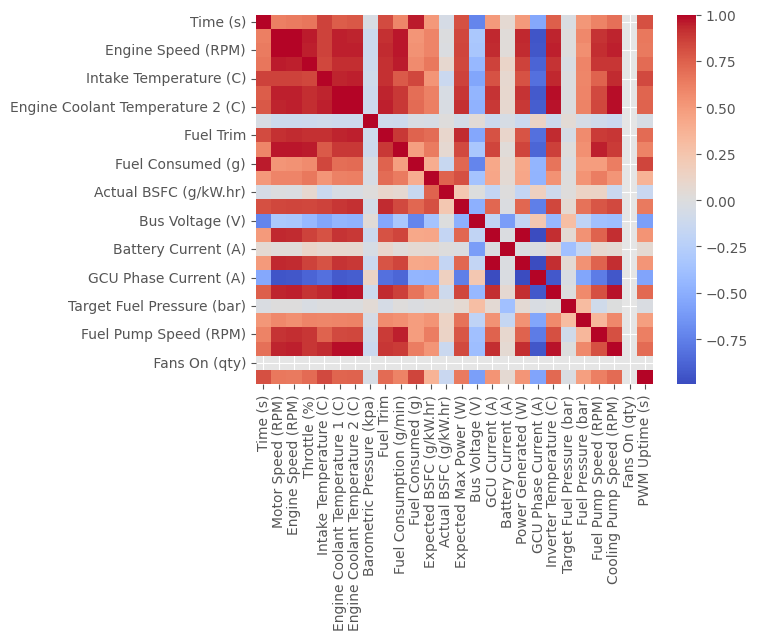

In [6]:
corr = df.corr()
sns.heatmap(corr, cmap = 'coolwarm')

In [7]:
def plot_distribution(features_to_plot, data, figsize = (20, 11), subtitle = None) :
    
    fig, axs = plt.subplots(2, len(features_to_plot), figsize = figsize)
    palette = sns.color_palette("husl", len(features_to_plot))
    if len(features_to_plot) == 1 :
        axs = np.array(axs).reshape(-1, 1)
    
    for index_c, ax_c in enumerate(axs) : 
        for index, ax in enumerate(ax_c) :
            mean = data[features_to_plot[index]].mean()
            median = data[features_to_plot[index]].median()
            if index_c == 0 :

                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    sns.distplot(data[features_to_plot[index]], ax=ax, color=palette[index])
                    ax.set_title(f'Distribution of {features_to_plot[index]}')
                    ax.axvline(mean, color='red', linestyle='dashed', linewidth=1.5, label = f'Mean:{mean:.2f}')
                    ax.axvline(median, color='green', linestyle='dotted', linewidth=1.5, label = f'Median:{median:.2f}')
                    ax.legend()
                    ax.grid()
            else :
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    sns.boxplot(data[features_to_plot[index]], color = palette[index], ax=ax, orient = 'h')
                    ax.axvline(median, color='green', linestyle='dotted', linewidth=1.5, label = f'Median:{median:.2f}')
                    ax.plot(mean, 0, marker='^', markersize=8, color='red', label=f'Mean:{mean:.2f}')
                    ax.legend()
                    ax.grid()

    plt.suptitle(subtitle, fontsize=14)
    plt.show()
    

In [9]:
numerical_cols = [col for col in df.columns[1:] if (df[col].dtype != 'object' and len(df[col].unique()) > 2)]
len(numerical_cols)

24

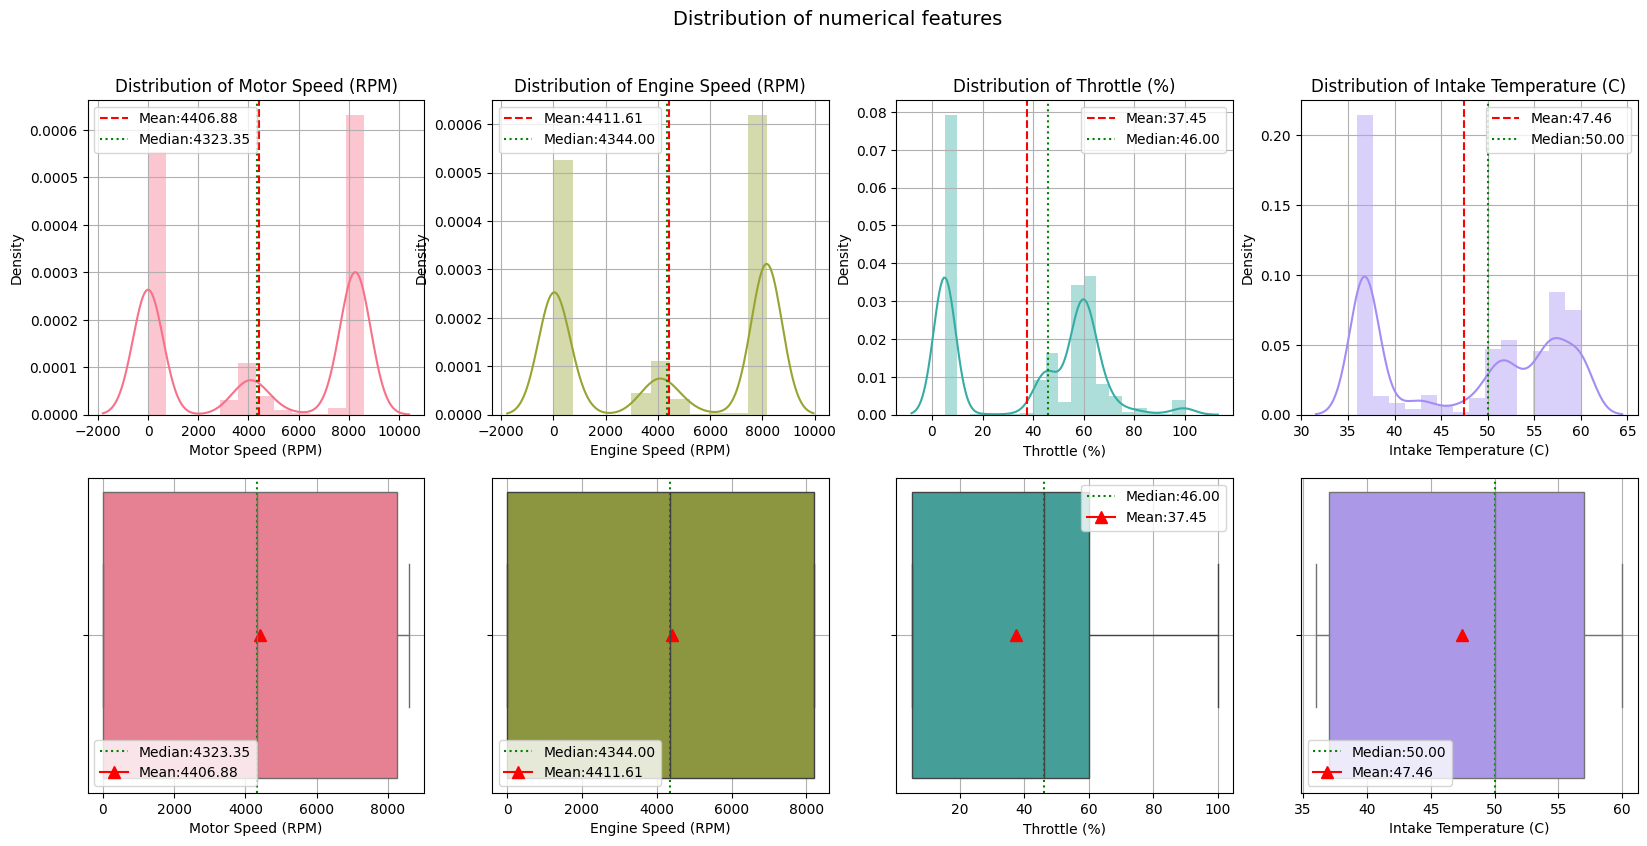

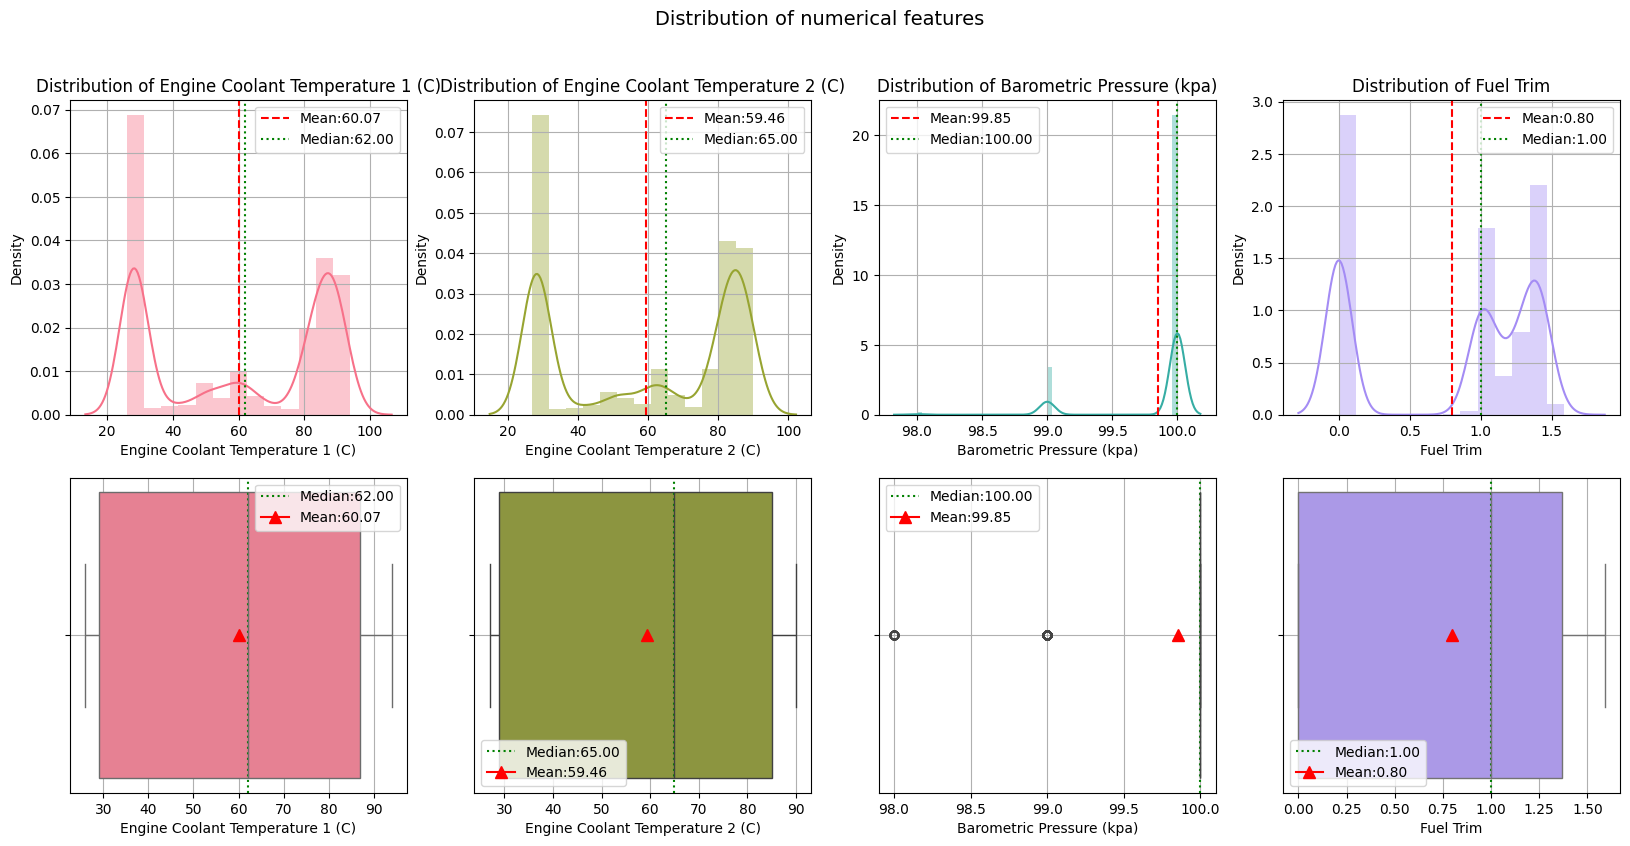

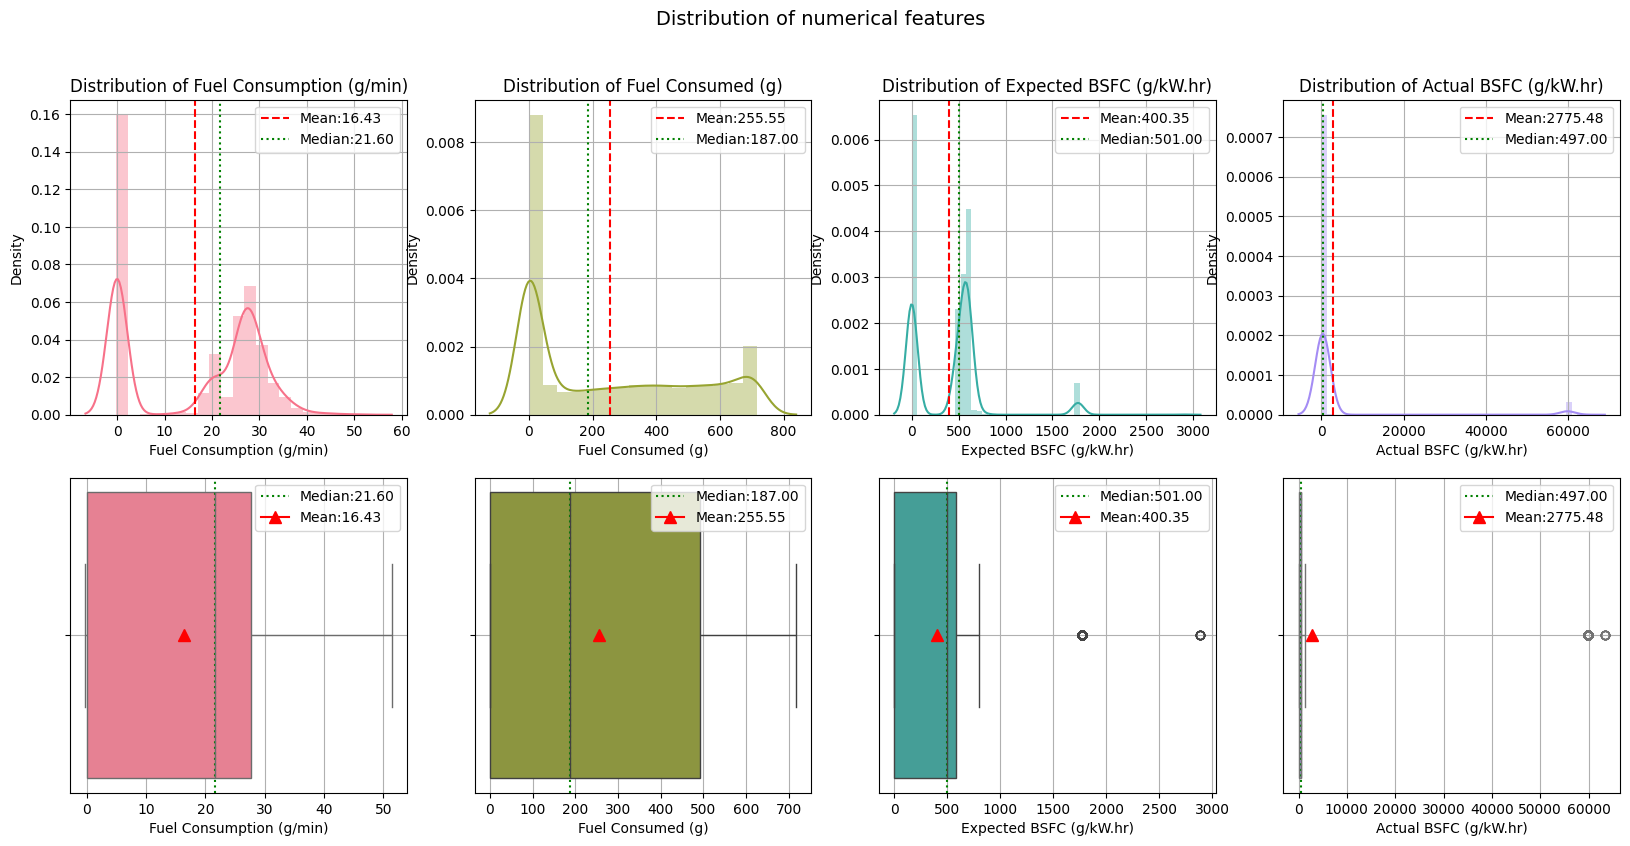

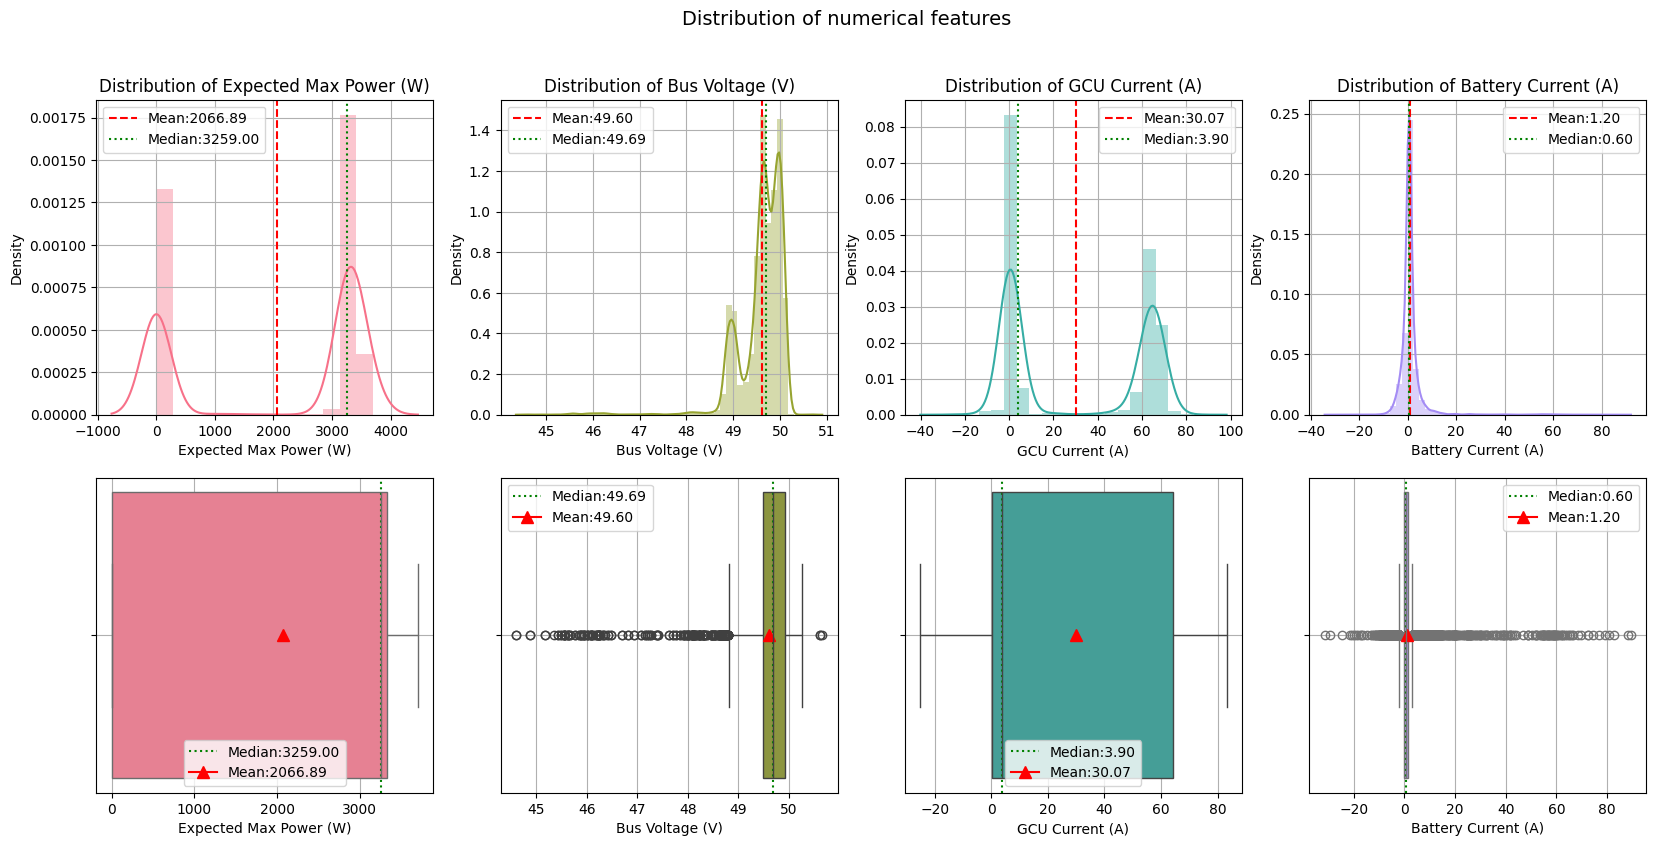

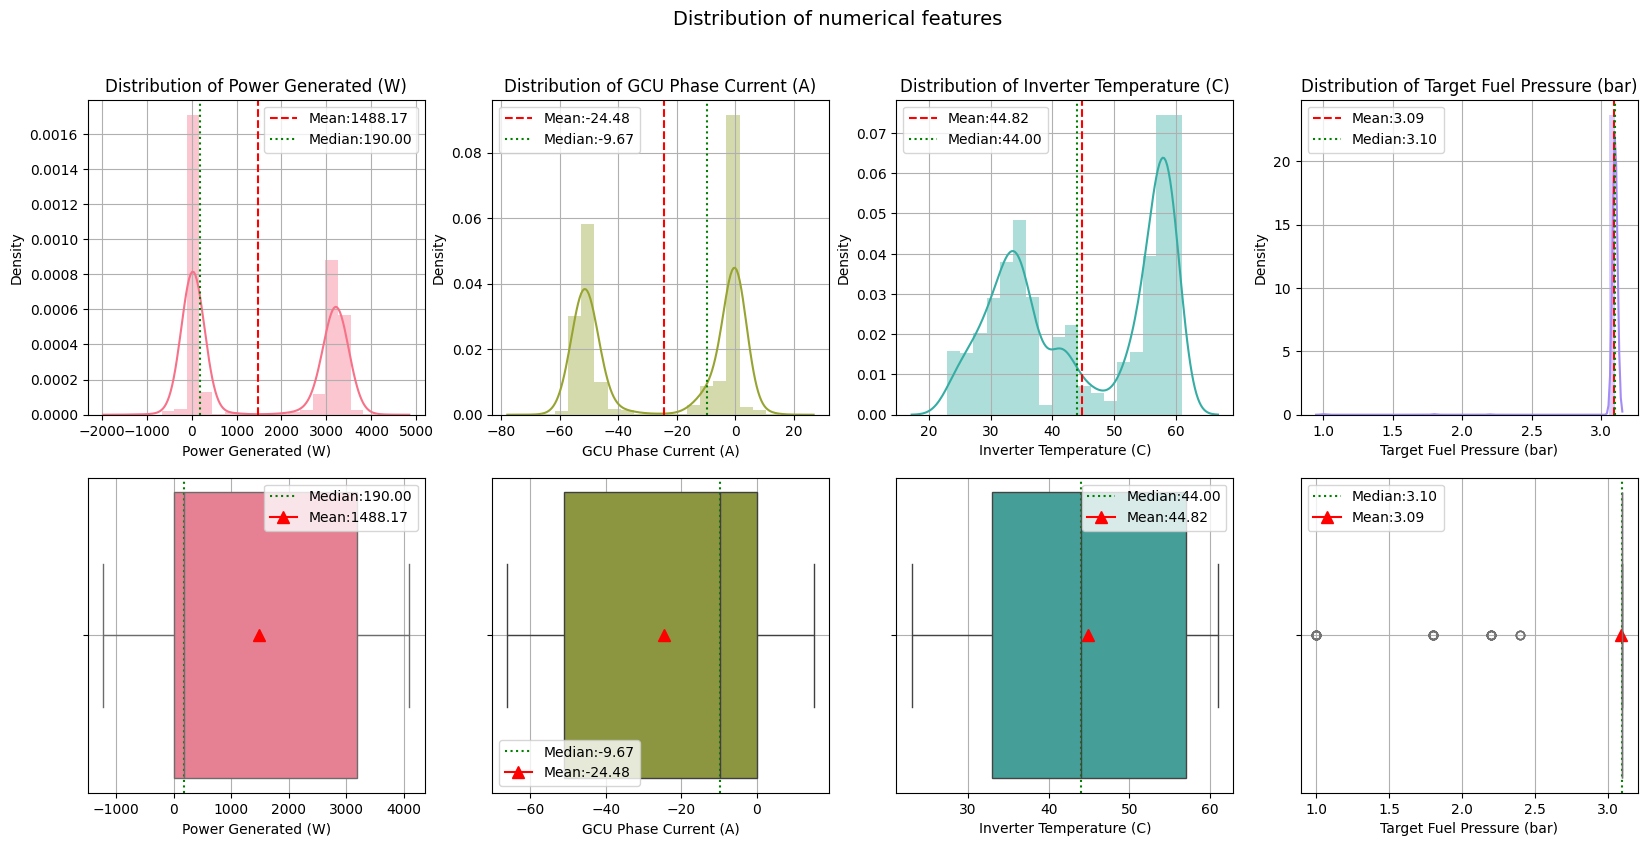

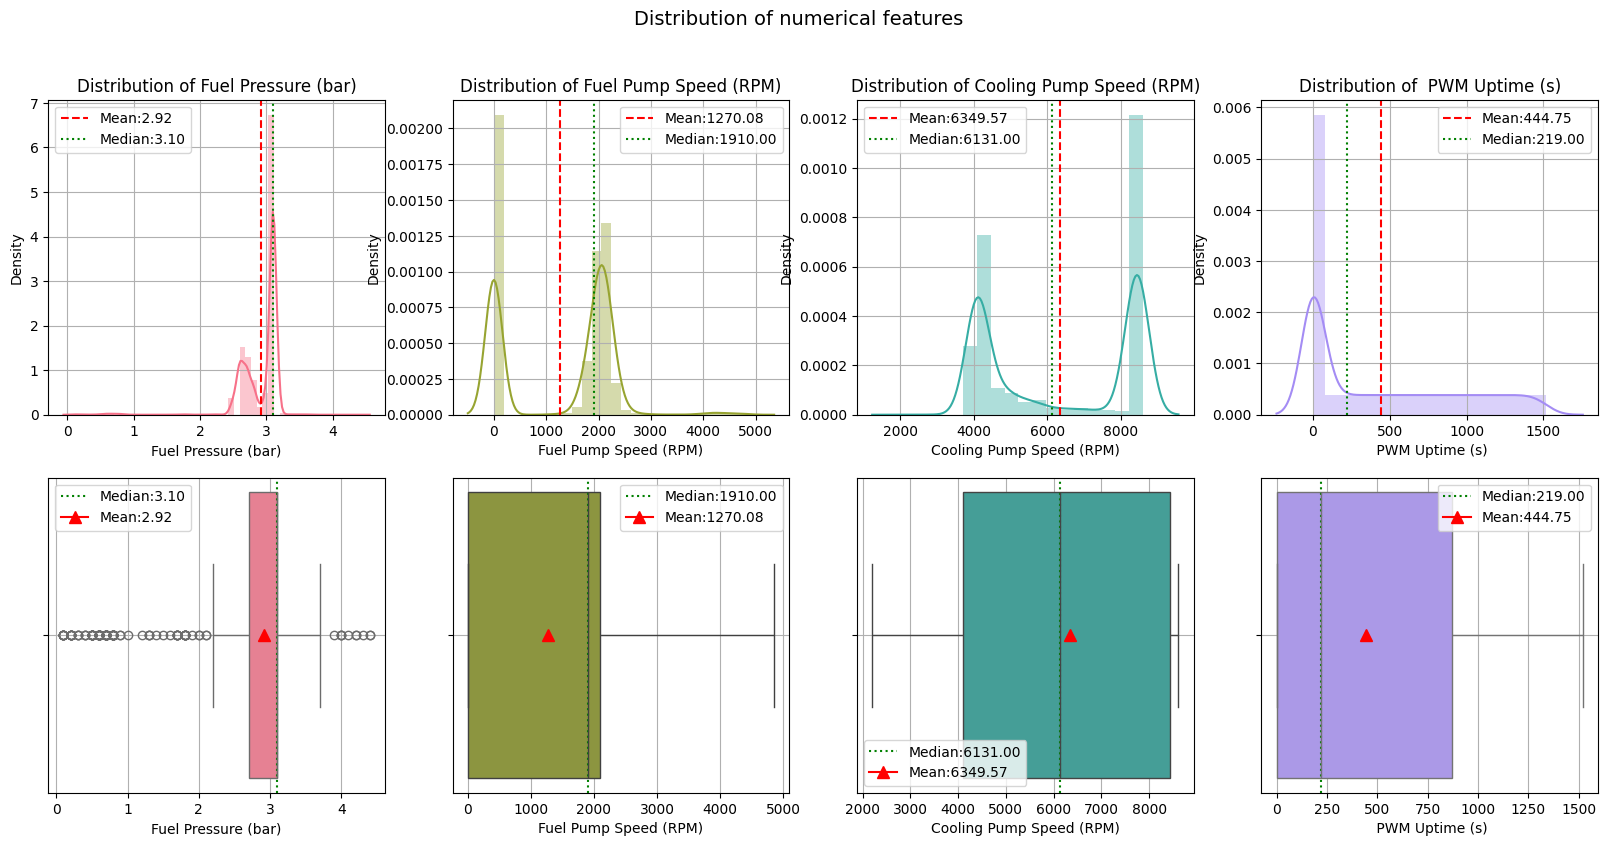

In [10]:
for i in range(0, len(numerical_cols), 4) :
    plot_distribution(numerical_cols[i:i+4], df, subtitle='Distribution of numerical features', figsize=(20, 9))

In [11]:
def compute_diff_plot(x1, x2, df, xlabel=None, bins=30):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
    
    # Define a colormap
    colormap = 'viridis'
    
    # Histogram 1
    sns.histplot(df[x1], kde=True, color=sns.color_palette(colormap, as_cmap=True)(0.2), label=x1, bins=bins, ax=ax1)
    sns.histplot(df[x2], kde=True, color=sns.color_palette(colormap, as_cmap=True)(0.8), label=x2, bins=bins, ax=ax1)
    
    # Labels and legend for Histogram
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('Frequency')
    ax1.set_title(f'Distribution of {x1} and {x2}')
    ax1.legend()
    
    # Hexbin plot
    hb = ax2.hexbin(df[x1], df[x2], gridsize=30, cmap=colormap, mincnt=1)
    cb = fig.colorbar(hb, ax=ax2, label='Count')
    ax2.set_xlabel(x1)
    ax2.set_ylabel(x2)
    ax2.set_title('Hexbin plot')
    
    # Adjust layout
    plt.tight_layout()
    
    # Compute t-test
    t_stat, p_value = ttest_ind(df[x1], df[x2])
    
    return t_stat, p_value


t-statistic: 0.09059709050398988
p-value: 0.9278136108101815
Fail to reject the null hypothesis: There is no significant difference between the two.


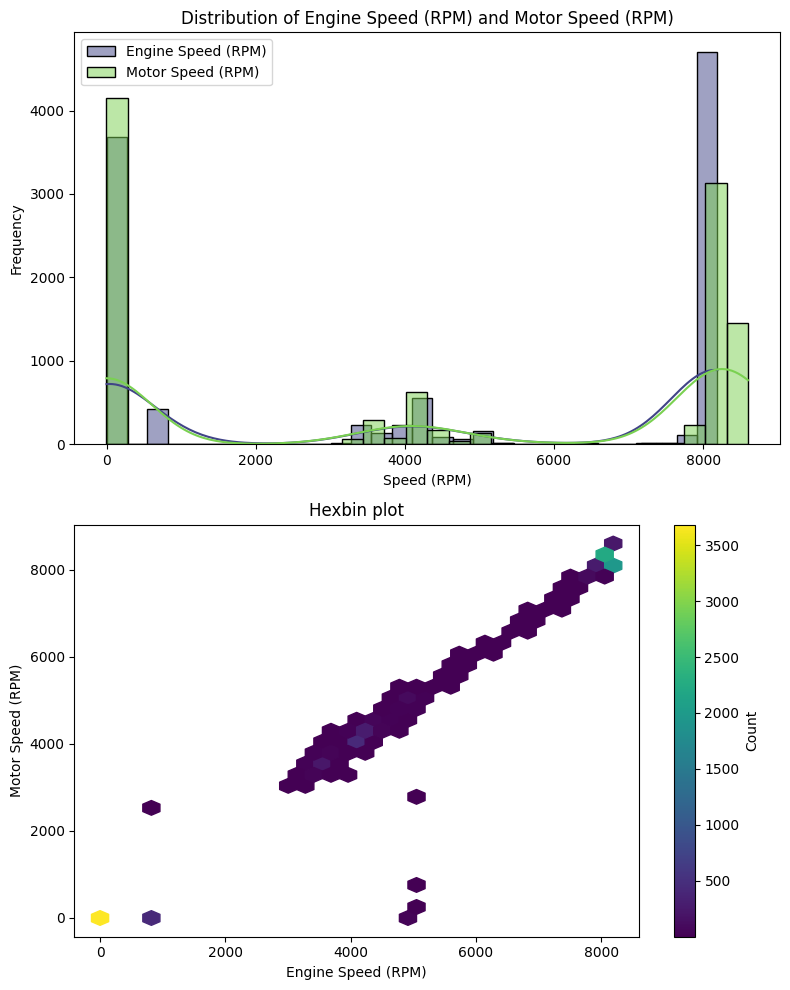

In [12]:
t_stat, p_value = compute_diff_plot('Engine Speed (RPM)', 'Motor Speed (RPM)', df, xlabel='Speed (RPM)')
print(f't-statistic: {t_stat}')
print(f'p-value: {p_value}')

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the two.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the two.")

In [13]:
df['Average Speed (RPM)'] = df[['Engine Speed (RPM)', 'Motor Speed (RPM)']].mean(axis=1)

# Drop the original columns if needed
df = df.drop(columns=['Engine Speed (RPM)', 'Motor Speed (RPM)'])

t-statistic: 1.6961490922674196
p-value: 0.08987251970828689
Fail to reject the null hypothesis: There is no significant difference between the two.


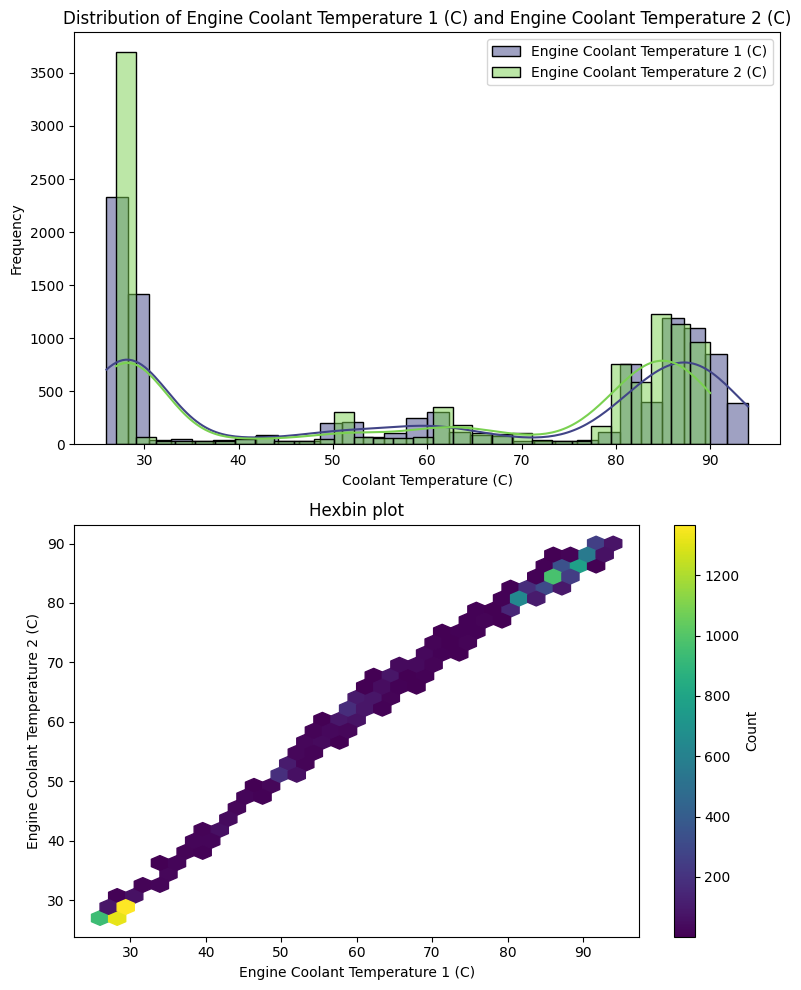

In [14]:
t_stat, p_value = compute_diff_plot('Engine Coolant Temperature 1 (C)', 'Engine Coolant Temperature 2 (C)', xlabel='Coolant Temperature (C)', df=df)
print(f't-statistic: {t_stat}')
print(f'p-value: {p_value}')

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the two.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the two.")

In [15]:
df['Average Engine Coolant Temperature (C)'] = df[['Engine Coolant Temperature 1 (C)', 'Engine Coolant Temperature 2 (C)']].mean(axis=1)

# Drop the original columns if needed
df = df.drop(columns=['Engine Coolant Temperature 1 (C)', 'Engine Coolant Temperature 2 (C)'])

In [8]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df.drop(columns=['Time (s)']))

In [9]:
k_values = range(2, 21)

wcss = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)

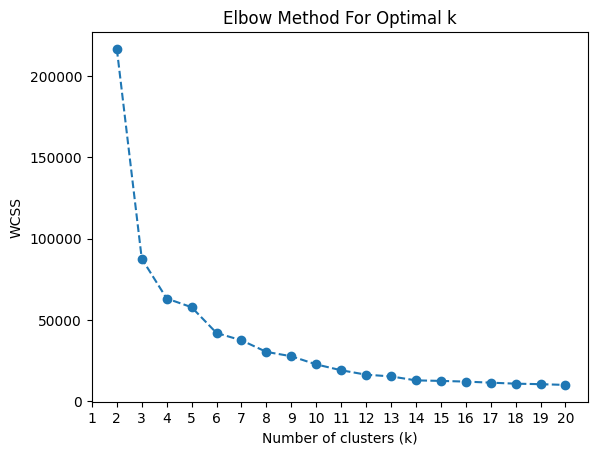

In [18]:
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method For Optimal k')
plt.xticks(ticks=list(range(1, 21)))
plt.show()

In [10]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(data_scaled)
clusters_kmeans = kmeans.predict(data_scaled)

In [11]:
clusters_kmeans

array([2, 2, 2, ..., 3, 3, 3])

In [12]:
pca = PCA(n_components=2)
X_pca_reduced = pca.fit_transform(data_scaled)

In [13]:
value, counts = np.unique(clusters_kmeans, return_counts=True)
clusters_counts_kmeans_df = pd.DataFrame({'value': value, 'counts' : counts})
clusters_counts_kmeans_df

value  counts
0      0      84
1      1    4837
2      2    3930
3      3    1615

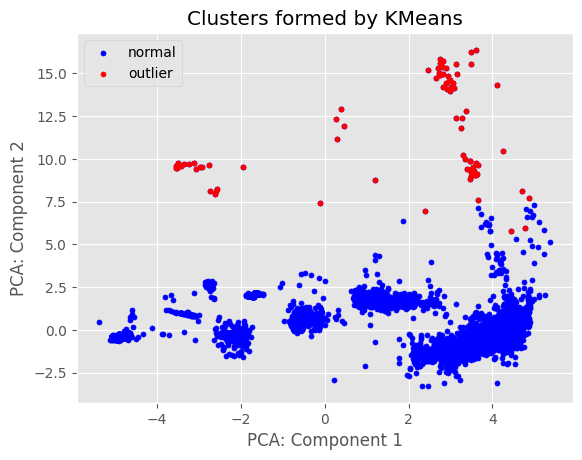

In [14]:
plt.scatter(X_pca_reduced[:, 0], X_pca_reduced[:, 1], c='blue', cmap='viridis', s = 13, label='normal')
plt.scatter(X_pca_reduced[:, 0][clusters_kmeans == 0], X_pca_reduced[:, 1][clusters_kmeans == 0], cmap='viridis', c='red', s = 13, label='outlier')
plt.xlabel('PCA: Component 1')
plt.ylabel('PCA: Component 2')
plt.title('Clusters formed by KMeans')
plt.legend()

In [25]:
alert_idx = 0

In [26]:
alert_idx += 1
df[f'ALERT{alert_idx}'] = 0
df[f'ALERT{alert_idx}'][clusters_kmeans == 0] = 1 

In [27]:
dbscan = DBSCAN(eps=6, min_samples=10)
clusters_dbscan = dbscan.fit_predict(data_scaled)

In [28]:
clusters_dbscan

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [29]:
value, counts = np.unique(clusters_dbscan, return_counts=True)
clusters_counts_dbscan_df = pd.DataFrame({'value': value, 'counts' : counts})
clusters_counts_dbscan_df

value  counts
0     -1      11
1      0   10403
2      1      17
3      2      35

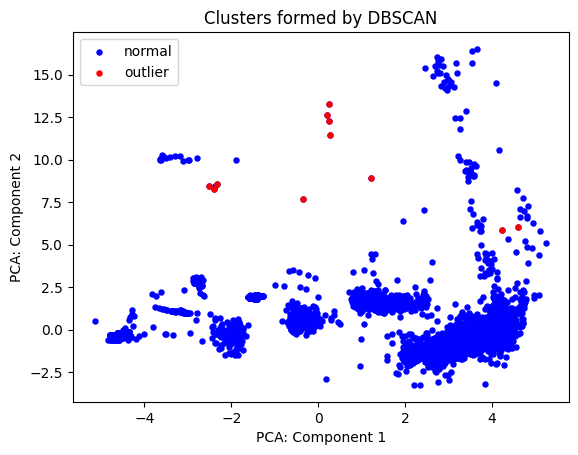

In [31]:
plt.scatter(X_pca_reduced[:, 0], X_pca_reduced[:, 1], c='blue', cmap='viridis', s = 13, label='normal')
plt.scatter(X_pca_reduced[:, 0][clusters_dbscan == -1], X_pca_reduced[:, 1][clusters_dbscan == -1], cmap='viridis', c='red', s = 13, label='outlier')
plt.xlabel('PCA: Component 1')
plt.ylabel('PCA: Component 2')
plt.title('Clusters formed by DBSCAN')
plt.legend()

In [86]:
alert_idx += 1
df[f'ALERT{alert_idx}'] = 0
df[f'ALERT{alert_idx}'][clusters_dbscan == -1] = 1 

In [87]:
z_scores = np.abs((data_scaled - np.mean(data_scaled, axis=0)) / np.std(data_scaled, axis=0))
outlier_indices_z = np.where(z_scores > 3)[0]
print(f"Z-Score Outliers: {len(outlier_indices_z)}")

Z-Score Outliers: 1420


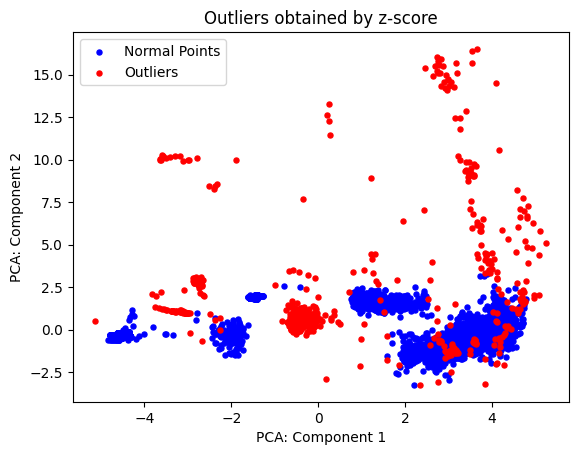

In [88]:
c = np.zeros_like(X_pca_reduced[:, 0])
c[outlier_indices_z] = -1
normal_points = plt.scatter(X_pca_reduced[c == 0, 0], X_pca_reduced[c == 0, 1], color='blue', label='Normal Points', s= 13, cmap='virdis')
outliers = plt.scatter(X_pca_reduced[c == -1, 0], X_pca_reduced[c == -1, 1], color='red', label='Outliers', s= 13, cmap='virdis')
plt.xlabel('PCA: Component 1')
plt.ylabel('PCA: Component 2')
plt.title('Outliers obtained by z-score')
plt.legend()

In [89]:
alert_idx += 1
df[f'ALERT{alert_idx}'] = 0
df[f'ALERT{alert_idx}'][clusters_dbscan == -1] = 1 

In [90]:
iso_forest = IsolationForest(contamination=0.01)
outliers_if = iso_forest.fit_predict(data_scaled)
outlier_indices_if = np.where(outliers_if == -1)[0]
print(f"Isolation Forest Outliers: {len(outlier_indices_if)}")

Isolation Forest Outliers: 105


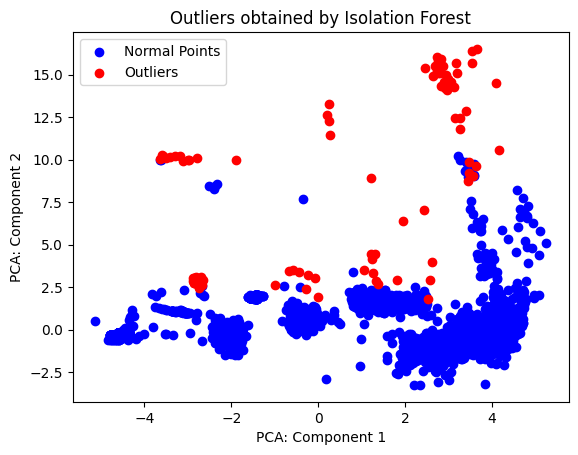

In [91]:
c = np.zeros_like(X_pca_reduced[:, 0])
c[outlier_indices_if] = -1
normal_points = plt.scatter(X_pca_reduced[c == 0, 0], X_pca_reduced[c == 0, 1], color='blue', label='Normal Points')
outliers = plt.scatter(X_pca_reduced[c == -1, 0], X_pca_reduced[c == -1, 1], color='red', label='Outliers')
plt.xlabel('PCA: Component 1')
plt.ylabel('PCA: Component 2')
plt.title('Outliers obtained by Isolation Forest')
plt.legend()

In [92]:
alert_idx += 1
df[f'ALERT{alert_idx}'] = 0
df[f'ALERT{alert_idx}'][outlier_indices_if] = 1

In [93]:
def plot_n_compute(X_names, y_name, df, model=None) :
    '''
    Plots and computes the outliers
    ---------------------------------
    Args :
    X_names : list
    List of column names
    
    y_name : str
    Target column name
    
    -------------------------------
    Returns :
    <Dataframe>
    Outlier input data points from original df
    
    '''

    X = df[X_names].values
    y = df[y_name].values

    # Create and fit the model
    if model == None :
        model = LinearRegression()
    model.fit(X, y)

    # Predict average speed based on the model
    y_pred = model.predict(X)

    # Calculate residuals (differences between actual and predicted speeds)
    residuals = y_pred - y
    y_std = residuals.std()
    threshold = 3.0 * y_std

    # Identify outliers
    outliers = df[np.abs(residuals) > threshold]

    # X_new = np.linspace(X.min(), X.max(), X.ravel().shape[0]).reshape(X.shape)
    # y_pred_X_new = model.predict(X_new)

    # Highlight outliers in the scatter plot
    for x_col_name in X_names:
        plt.figure(figsize=(14, 6))
        sns.scatterplot(x=x_col_name, y=y_name, data=df, label='Normal', s=15)
        sns.scatterplot(x=x_col_name, y=y_name, data=outliers, color='red', label='Outliers', s=15)
        plt.xlabel(x_col_name)
        plt.ylabel(y_name)
        plt.title(f'{x_col_name} vs {y_name} with Outliers Highlighted')
        plt.legend()
        
    return outliers

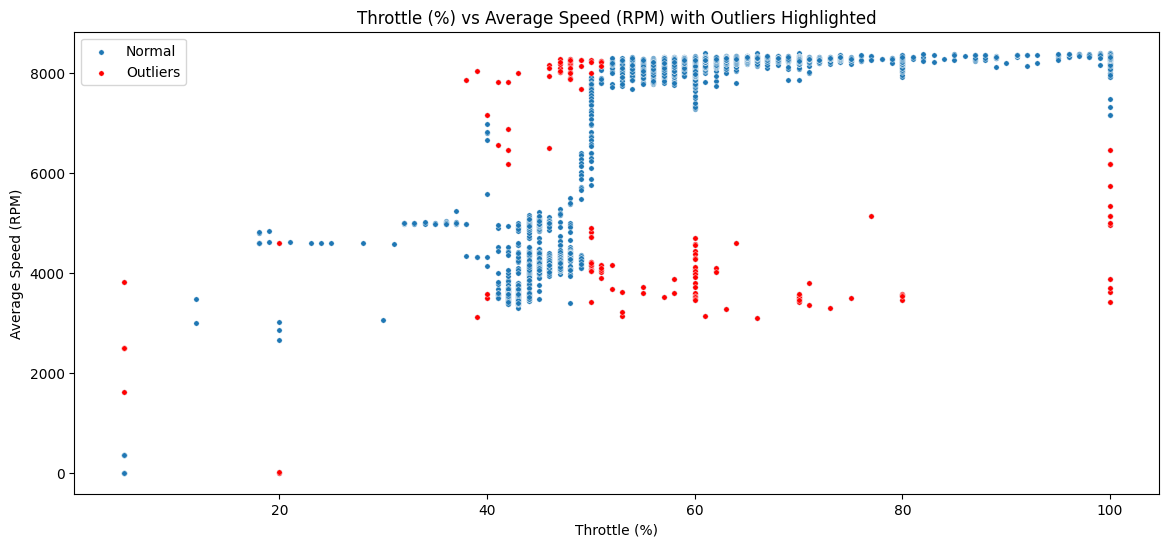

In [94]:
outliers_xgb = plot_n_compute(X_names=['Throttle (%)'], y_name='Average Speed (RPM)', df=df, model=XGBRegressor());

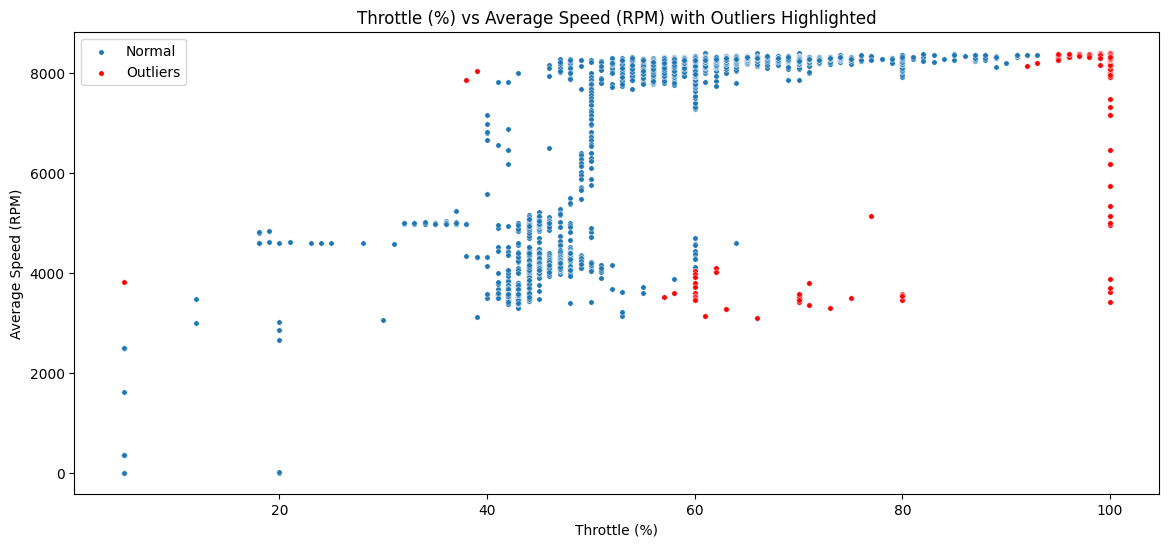

In [95]:
outliers_lin_reg = plot_n_compute(X_names=['Throttle (%)'], y_name='Average Speed (RPM)', df=df, model=LinearRegression());

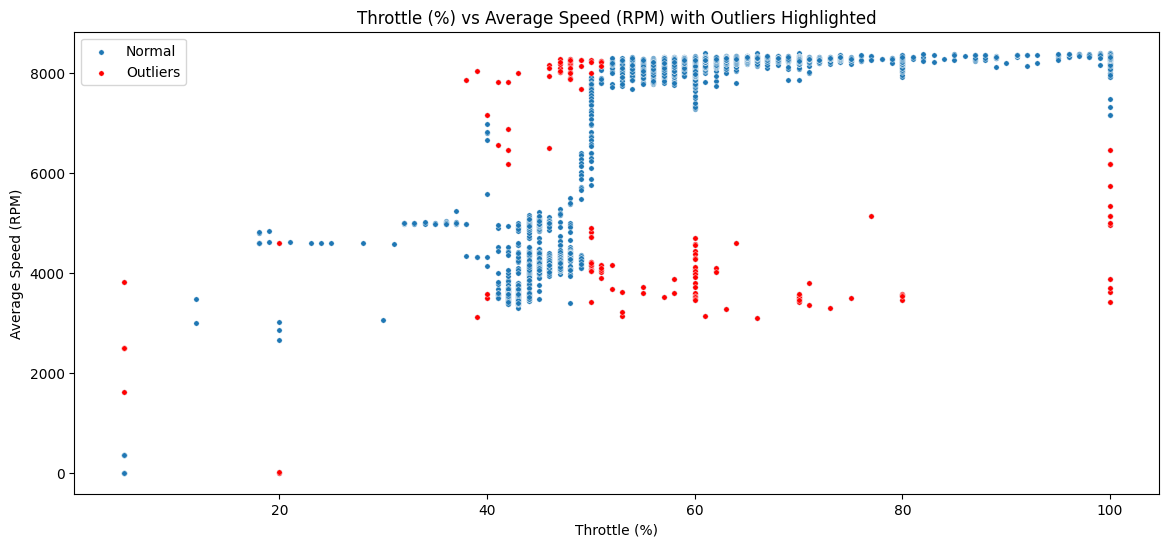

In [96]:
outliers_rand_forest = plot_n_compute(X_names=['Throttle (%)'], y_name='Average Speed (RPM)', df=df, model=RandomForestRegressor());

In [97]:
intersection = pd.merge(outliers_lin_reg, outliers_rand_forest, how='inner', left_index=True, right_index=True)
intersection = pd.merge(intersection, outliers_xgb, how='inner', left_index=True, right_index=True)
intersection.shape

(64, 84)

In [98]:
def plot_x_y(x, y, df, outlier_df, title=None) :
    plt.figure(figsize=(20, 5))
    sns.lineplot(x=x, y=y, data=df)
    sns.scatterplot(x=x, y=y, data=outlier_df, color='red', label='Outliers')
    plt.legend()
    plt.show()

<Axes: xlabel='Time (s)', ylabel='Throttle (%)'>

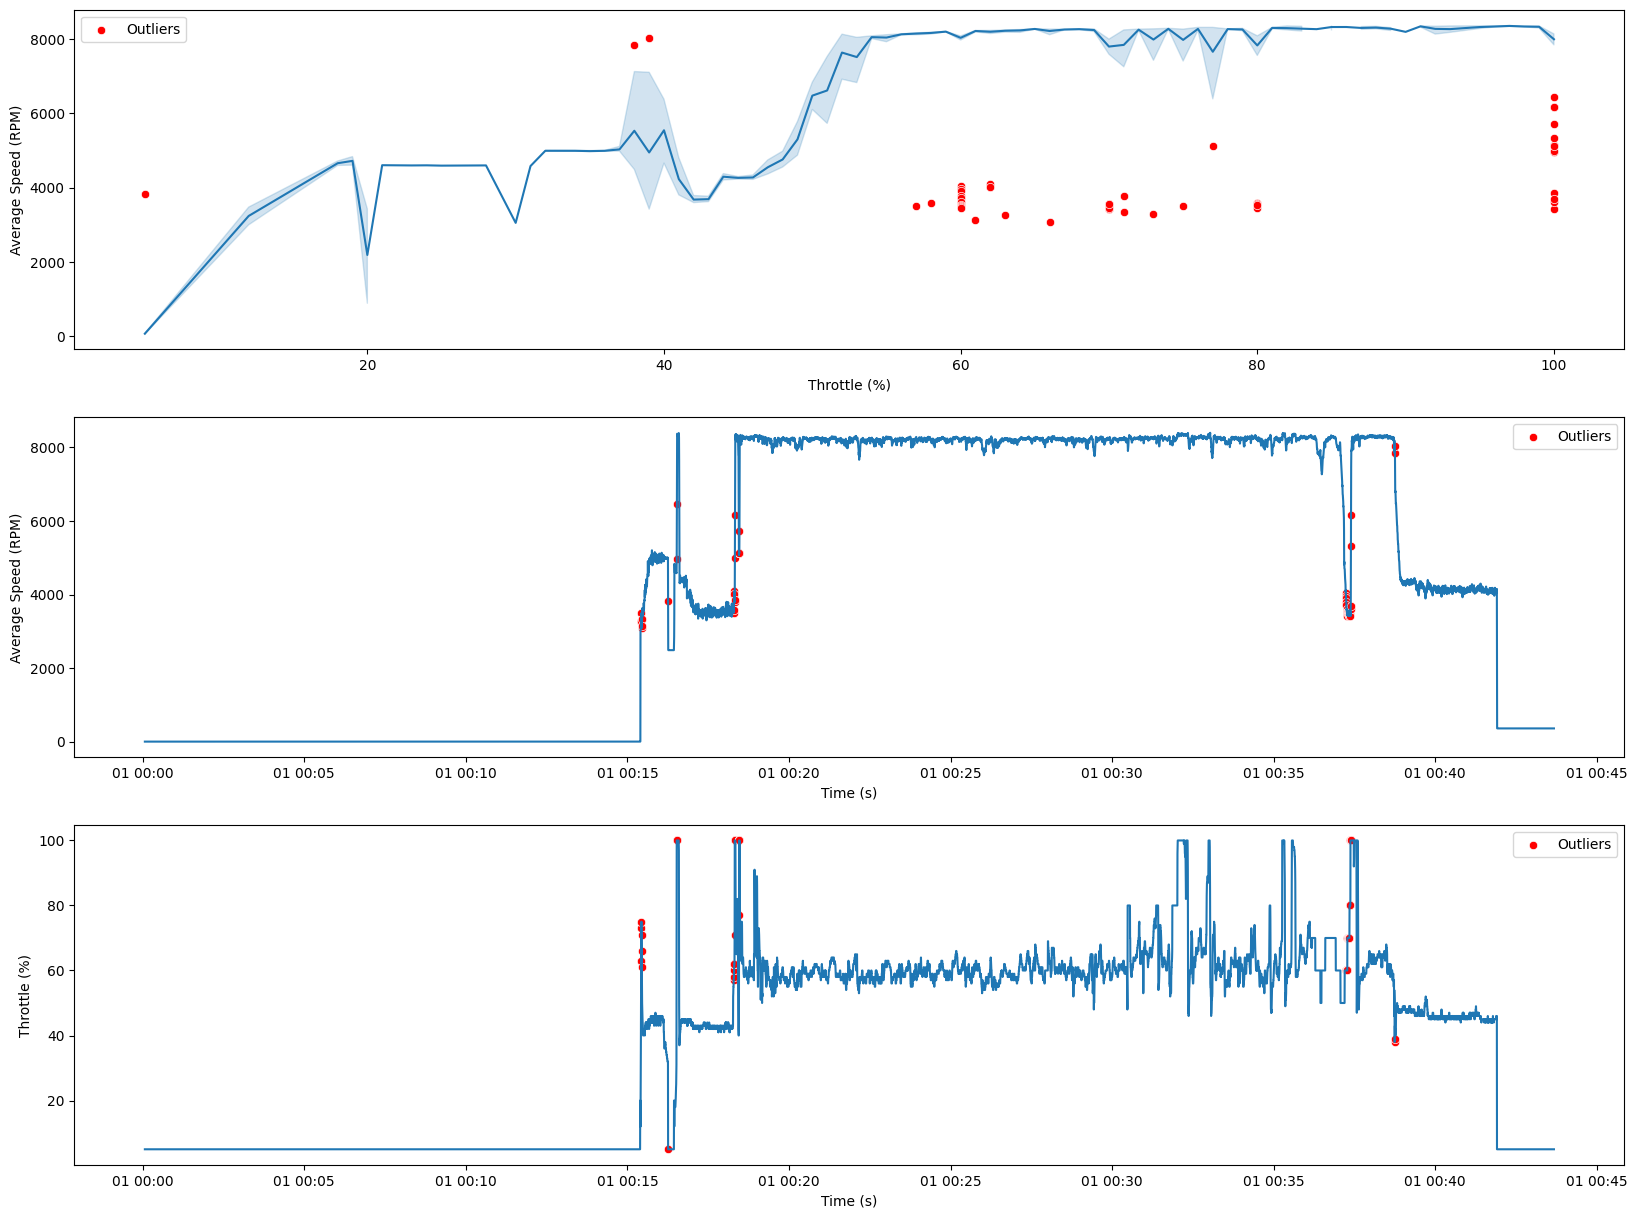

In [99]:
plt.figure(figsize=(20, 15))
ax1 = plt.subplot(3, 1, 1)
sns.lineplot(x='Throttle (%)', y='Average Speed (RPM)', data=df, ax=ax1)
sns.scatterplot(x='Throttle (%)', y='Average Speed (RPM)', data=intersection, color='red', label='Outliers', ax=ax1)

# plt.figure(figsize=(20, 5))
ax2 = plt.subplot(3, 1, 2)
sns.lineplot(x='Time (s)', y='Average Speed (RPM)', data=df)
sns.scatterplot(x='Time (s)', y='Average Speed (RPM)', data=intersection, color='red', label='Outliers')

# plt.figure(figsize=(20, 5))
ax3 = plt.subplot(3, 1, 3)
sns.lineplot(x='Time (s)', y='Throttle (%)', data=df)
sns.scatterplot(x='Time (s)', y='Throttle (%)', data=intersection, color='red', label='Outliers')

In [100]:
alert_idx += 1
df[f'ALERT{alert_idx}'] = 0
df[f'ALERT{alert_idx}'][intersection.index] = 1
df[f'ALERT{alert_idx}'].value_counts()

ALERT5
0    10402
1       64
Name: count, dtype: int64

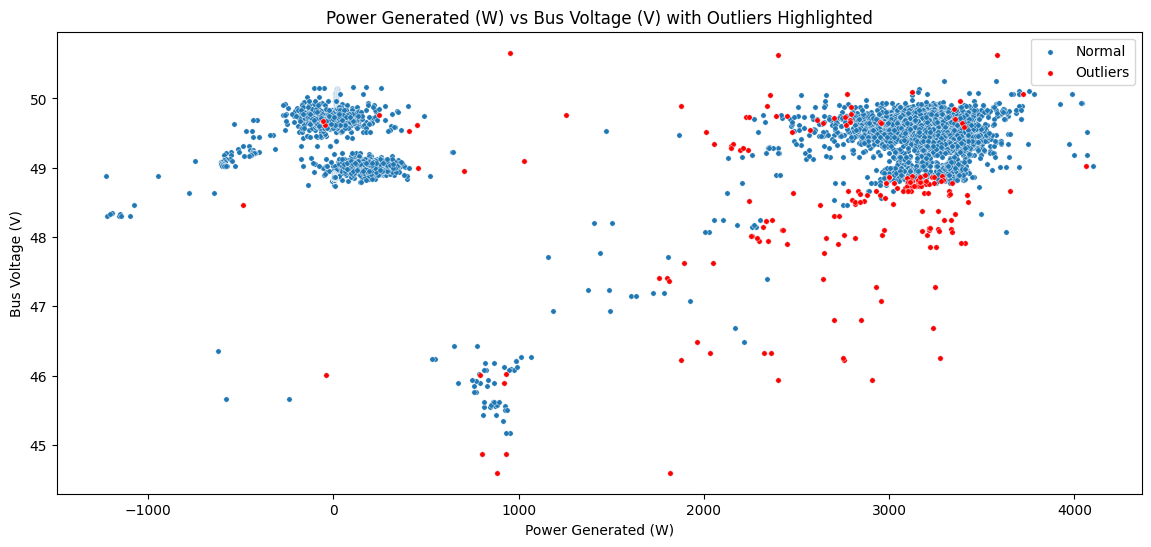

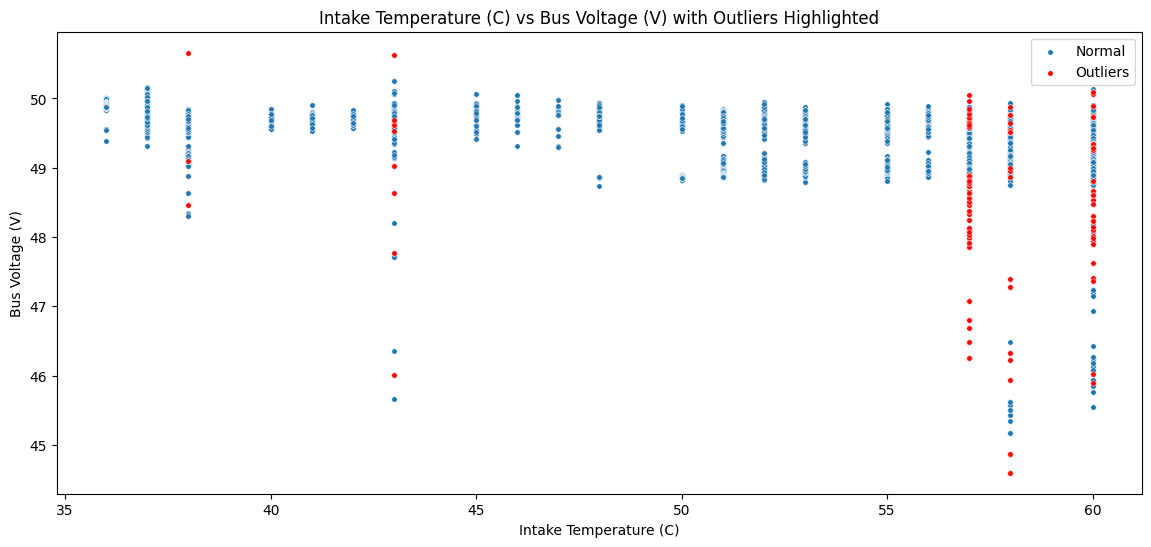

In [101]:
outliers_xgb = plot_n_compute(X_names=['Power Generated (W)', 'Intake Temperature (C)'], y_name='Bus Voltage (V)', df=df, model=XGBRegressor());

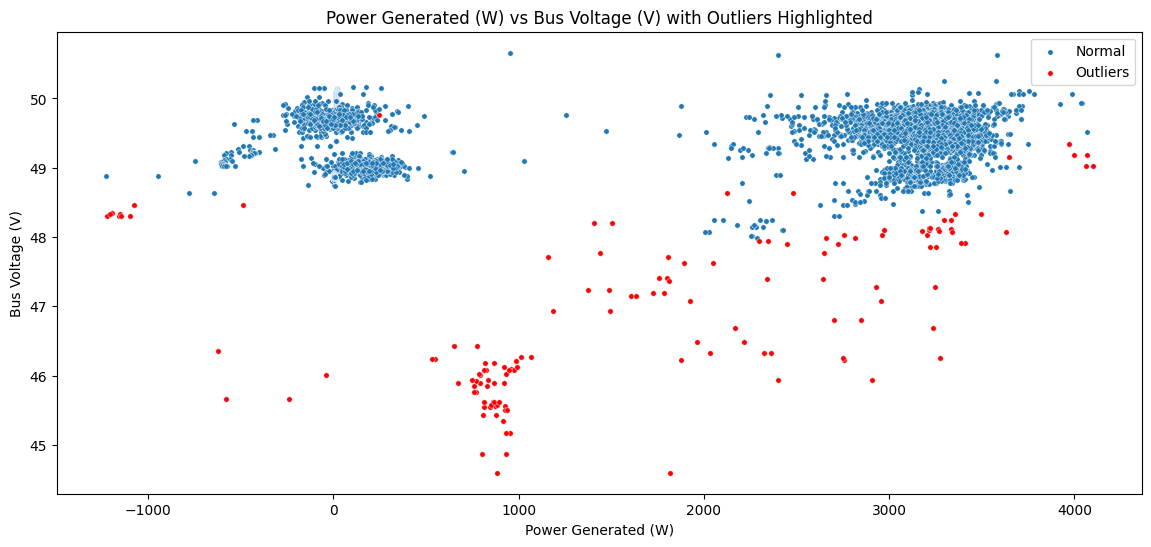

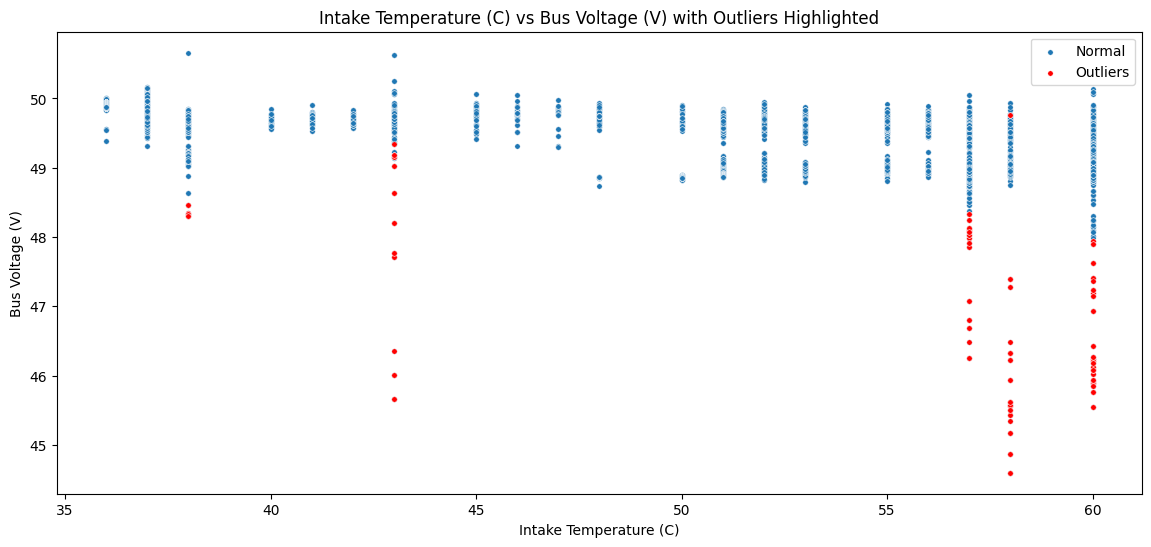

In [102]:
outliers_lin_reg = plot_n_compute(X_names=['Power Generated (W)', 'Intake Temperature (C)'], y_name='Bus Voltage (V)', df=df, model=LinearRegression());

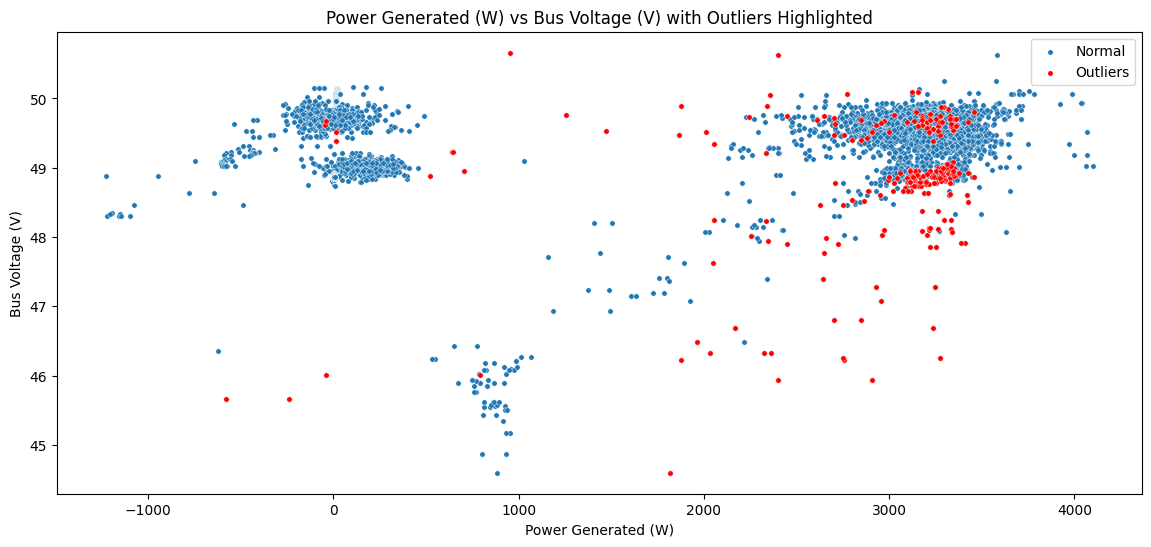

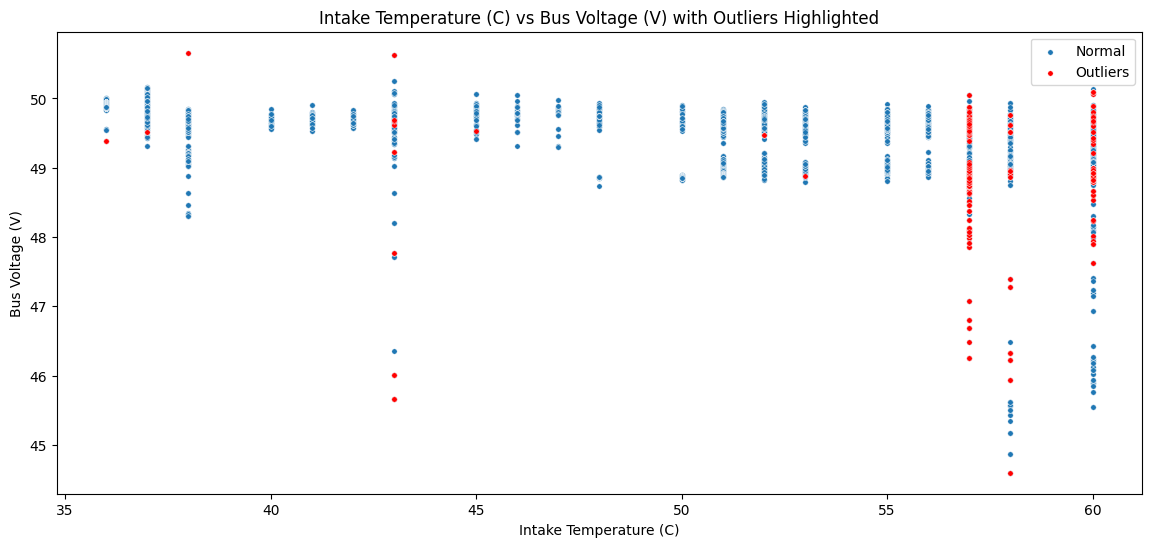

In [103]:
outliers_rand_forest = plot_n_compute(X_names=['Power Generated (W)', 'Intake Temperature (C)'], y_name='Bus Voltage (V)', df=df, model=RandomForestRegressor());

In [104]:
intersection = pd.merge(outliers_lin_reg, outliers_rand_forest, how='inner', left_index=True, right_index=True)
intersection = pd.merge(intersection, outliers_xgb, how='inner', left_index=True, right_index=True)
intersection.shape

(42, 87)

In [105]:
alert_idx += 1
df[f'ALERT{alert_idx}'] = 0
df[f'ALERT{alert_idx}'][intersection.index] = 1
df[f'ALERT{alert_idx}'].value_counts()

ALERT6
0    10424
1       42
Name: count, dtype: int64

## Considering temporal features

In [16]:
df.select_dtypes(include=[int, float]).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10466 entries, 0 to 10465
Data columns (total 23 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Throttle (%)                            10466 non-null  int64  
 1   Intake Temperature (C)                  10466 non-null  int64  
 2   Barometric Pressure (kpa)               10466 non-null  int64  
 3   Fuel Trim                               10466 non-null  float64
 4   Fuel Consumption (g/min)                10466 non-null  float64
 5   Fuel Consumed (g)                       10466 non-null  int64  
 6   Expected BSFC (g/kW.hr)                 10466 non-null  int64  
 7   Actual BSFC (g/kW.hr)                   10466 non-null  int64  
 8   Expected Max Power (W)                  10466 non-null  int64  
 9   Bus Voltage (V)                         10466 non-null  float64
 10  GCU Current (A)                         10466 non-null  fl

In [17]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df.select_dtypes(include=[int, float]))
data_scaled_df = pd.DataFrame(columns=df.select_dtypes(include=[int, float]).columns, data=data_scaled)

In [18]:
data_scaled.shape

(10466, 23)

In [19]:
T = 20
D = 1

In [10]:
x_idx = data_scaled_df.columns.get_loc('Throttle (%)')
y_idx = [data_scaled_df.columns.get_loc(x) for x in ['Average Speed (RPM)']]
T = 20
D = 1
X = []
Y = []

for t in range(len(data_scaled) - T) :
    x = data_scaled[t : t + T, x_idx]
    y = data_scaled[t + T, y_idx]
    X.append(x)
    Y.append(y)
    
X = np.array(X).reshape(-1, T, D)
Y = np.array(Y)
N = len(X)
print(X.shape, Y.shape)

(10366, 100, 1) (10366,)


In [20]:
#LSTM model
i = Input(shape = (T, D))
x = LSTM(50) (i)
x = Activation('relu') (x)
x = Dense(1) (x)

model = Model(i, x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 activation (Activation)     (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [22]:
def m2tex(model):
    stringlist = []
    model.summary(line_length=70, print_fn=lambda x: stringlist.append(x))
    del stringlist[1:-4:2]
    del stringlist[-1]
    for ix in range(1,len(stringlist)-3):
        tmp = stringlist[ix]
        stringlist[ix] = tmp[0:31]+"& "+tmp[31:59]+"& "+tmp[59:]+"\\\\ \hline"
    stringlist[0] = "Model: test \\\\ \hline"
    stringlist[1] = stringlist[1]+" \hline"
    stringlist[-4] = stringlist[-4]+" \hline"
    stringlist[-3] = stringlist[-3]+" \\\\"
    stringlist[-2] = stringlist[-2]+" \\\\"
    stringlist[-1] = stringlist[-1]+" \\\\ \hline"
    prefix = ["\\begin{table}[]", "\\begin{tabular}{lll}"]
    suffix = ["\end{tabular}", "\caption{Model summary for test.}", "\label{tab:model-summary}" , "\end{table}"]
    stringlist = prefix + stringlist + suffix 
    out_str = " \n".join(stringlist)
    out_str = out_str.replace("_", "\_")
    out_str = out_str.replace("#", "\#")
    print(out_str)

In [23]:
m2tex(model)

\begin{table}[] 
\begin{tabular}{lll} 
Model: test \\ \hline 
 Layer (type)                  & Output Shape                & Param \#    \\ \hline \hline 
 input\_1 (InputLayer)          & [(None, 20, 1)]             & 0          \\ \hline 
 lstm (LSTM)                   & (None, 50)                  & 10400      \\ \hline 
 activation (Activation)       & (None, 50)                  & 0          \\ \hline 
 dense (Dense)                 & (None, 1)                   & 51         \\ \hline 
===============================& ============================& ===========\\ \hline \hline 
Total params: 10,451 \\ 
Trainable params: 10,451 \\ 
Non-trainable params: 0 \\ \hline 
\end{tabular} 
\caption{Model summary for test.} 
\label{tab:model-summary} 
\end{table}


In [95]:
model.compile(
	loss = 'mse',
    optimizer = Adam(learning_rate=0.0001)
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

r = model.fit(
    x=X,
    y=Y,
    validation_split=0.5,
    epochs = 100,
    workers=8,
    callbacks=[early_stopping]
)

Epoch 1/100
162/162 [==============================] - 4s 17ms/step - loss: 0.5202 - val_loss: 0.3878
Epoch 2/100
162/162 [==============================] - 2s 14ms/step - loss: 0.0522 - val_loss: 0.0486
Epoch 3/100
162/162 [==============================] - 2s 14ms/step - loss: 0.0251 - val_loss: 0.0366
Epoch 4/100
162/162 [==============================] - 2s 14ms/step - loss: 0.0198 - val_loss: 0.0311
Epoch 5/100
162/162 [==============================] - 2s 14ms/step - loss: 0.0174 - val_loss: 0.0254
Epoch 6/100
162/162 [==============================] - 3s 16ms/step - loss: 0.0159 - val_loss: 0.0251
Epoch 7/100
162/162 [==============================] - 2s 15ms/step - loss: 0.0149 - val_loss: 0.0223
Epoch 8/100
162/162 [==============================] - 3s 16ms/step - loss: 0.0138 - val_loss: 0.0215
Epoch 9/100
162/162 [==============================] - 3s 16ms/step - loss: 0.0129 - val_loss: 0.0213
Epoch 10/100
162/162 [==============================] - 3s 18ms/step - loss: 0.011

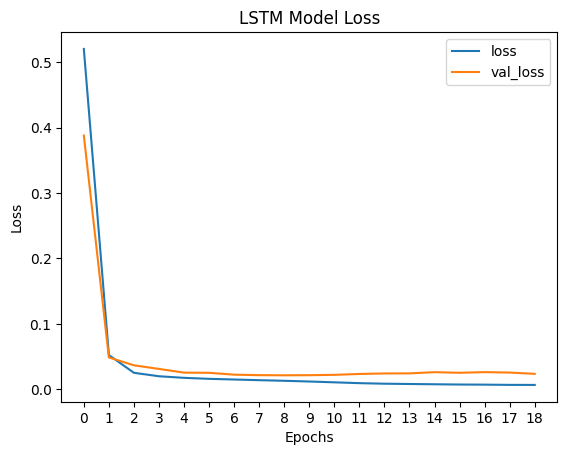

In [101]:
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.xticks(range(len(r.history['loss'])))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Model Loss')
plt.legend()

In [98]:
#one step forecast
validation_targets = Y[N//2:]
validation_predictions = []

i = N//2

while(len(validation_predictions) < len(validation_targets)) :
    x = X[i].reshape(1, T, D)
    p = model.predict(x, verbose=0)[0][0]
    
    validation_predictions.append(p)
    
    i += 1

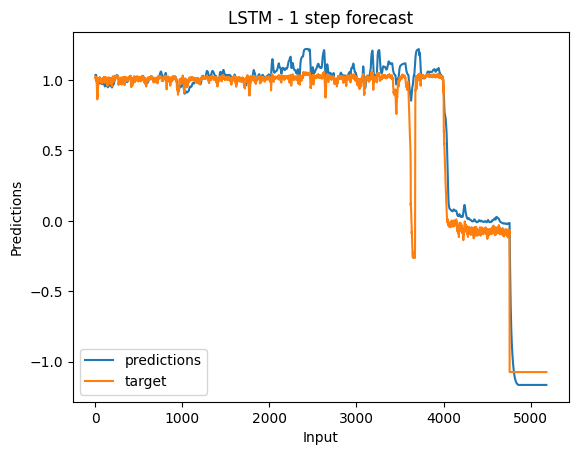

In [102]:
plt.plot(validation_predictions, label = 'predictions')
plt.plot(validation_targets, label = 'target')
plt.xlabel('Input')
plt.ylabel('Predictions')
plt.title('LSTM - 1 step forecast')
plt.legend()

In [103]:
#multi step forecast
validation_targets = Y[N//2:]
validation_predictions = []

last_x = X[N//2]

while(len(validation_predictions) < len(validation_targets)) :
    x = last_x.reshape(1, T, D)
    p = model.predict(x, verbose=0)[0][0]
    
    validation_predictions.append(p)
    
    last_x = np.roll(last_x, shift=-1)
    last_x[-1] = p

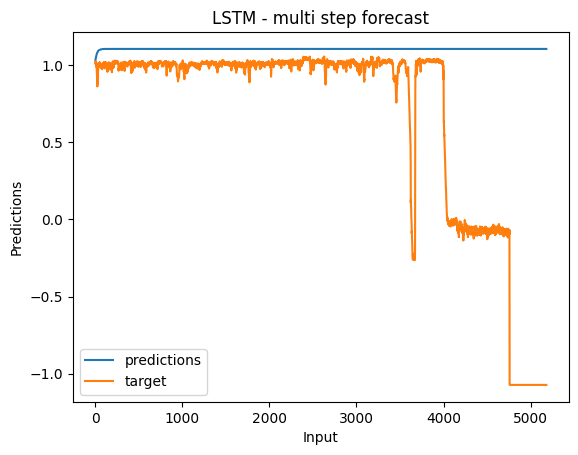

In [104]:
plt.plot(validation_predictions, label = 'predictions')
plt.plot(validation_targets, label = 'target')
plt.xlabel('Input')
plt.ylabel('Predictions')
plt.title('LSTM - multi step forecast')
plt.legend()

In [52]:
df.head()

Time (s)  Throttle (%)  Intake Temperature (C)  \
0 1970-01-01 00:00:04.040             5                      37   
1 1970-01-01 00:00:04.300             5                      37   
2 1970-01-01 00:00:04.540             5                      37   
3 1970-01-01 00:00:04.800             5                      37   
4 1970-01-01 00:00:05.040             5                      37   

   Barometric Pressure (kpa)  Fuel Trim  Fuel Consumption (g/min)  \
0                        100        0.0                       0.0   
1                        100        0.0                       0.0   
2                        100        0.0                       0.0   
3                        100        0.0                       0.0   
4                        100        0.0                       0.0   

   Fuel Consumed (g)  Expected BSFC (g/kW.hr)  Actual BSFC (g/kW.hr)  \
0                  0                        0                      0   
1                  0                        0                      0   
2                  0                        0                      0   
3                  0                        0                      0   
4                  0                        0                      0   

   Expected Max Power (W)  ...   PWM Uptime (s)  Average Speed (RPM)  \
0                       0  ...                4                  0.0   
1                       0  ...                5                  0.0   
2                       0  ...                5                  0.0   
3                       0  ...                5                  0.0   
4                       0  ...                5                  0.0   

   Average Engine Coolant Temperature (C)  ALERT2  ALERT3  ALERT4  ALERT5  \
0                                    26.5       0       0       0       0   
1                                    26.5       0       0       0       0   
2                                    26.5       0       0       0       0   
3                                    26.5       0       0       0       0   
4                                    26.5       0       0       0       0   

   ALERT6  ALERT7  ALERT8  
0       0       0       0  
1       0       0       0  
2       0       0       0  
3       0       0       0  
4       0       0       0  

[5 rows x 31 columns]

## GRU Model

In [11]:
#LSTM model
i = Input(shape = (T, D))
x = GRU(50) (i)
x = Activation('relu') (x)
x = Dense(1) (x)

model = Model(i, x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 1)]          0         
                                                                 
 gru (GRU)                   (None, 50)                7950      
                                                                 
 activation (Activation)     (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(
	loss = 'mse',
    optimizer = Adam(learning_rate=0.0001)
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

r = model.fit(
    x=X,
    y=Y,
    validation_split=0.5,
    epochs = 100,
    workers=8,
    callbacks=[early_stopping]
)

Epoch 1/100
162/162 [==============================] - 20s 62ms/step - loss: 0.8216 - val_loss: 0.4633
Epoch 2/100
162/162 [==============================] - 7s 45ms/step - loss: 0.1723 - val_loss: 0.1930
Epoch 3/100
162/162 [==============================] - 7s 40ms/step - loss: 0.0454 - val_loss: 0.0749
Epoch 4/100
162/162 [==============================] - 7s 42ms/step - loss: 0.0281 - val_loss: 0.0556
Epoch 5/100
162/162 [==============================] - 7s 42ms/step - loss: 0.0205 - val_loss: 0.0507
Epoch 6/100
162/162 [==============================] - 7s 44ms/step - loss: 0.0178 - val_loss: 0.0466
Epoch 7/100
162/162 [==============================] - 7s 41ms/step - loss: 0.0168 - val_loss: 0.0419
Epoch 8/100
162/162 [==============================] - 7s 45ms/step - loss: 0.0160 - val_loss: 0.0378
Epoch 9/100
162/162 [==============================] - 7s 43ms/step - loss: 0.0154 - val_loss: 0.0343
Epoch 10/100
162/162 [==============================] - 7s 44ms/step - loss: 0.01

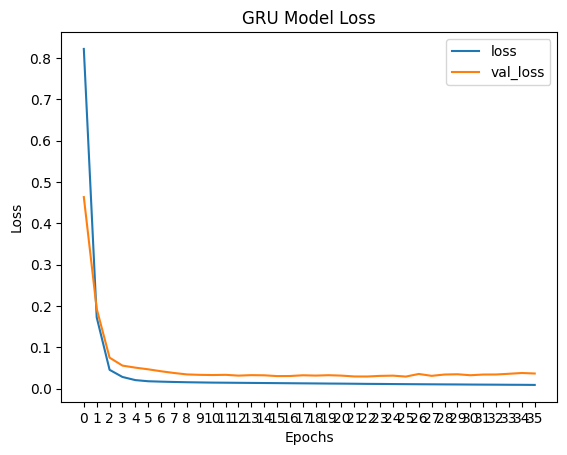

In [15]:
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.xticks(range(len(r.history['loss'])))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GRU Model Loss')
plt.legend()

In [16]:
#one step forecast
validation_targets = Y[N//2:]
validation_predictions = []

i = N//2

while(len(validation_predictions) < len(validation_targets)) :
    x = X[i].reshape(1, T, D)
    p = model.predict(x, verbose=0)[0][0]
    
    validation_predictions.append(p)
    
    i += 1

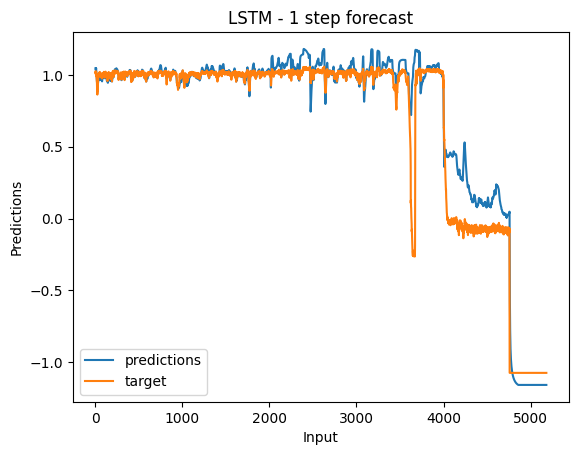

In [17]:
plt.plot(validation_predictions, label = 'predictions')
plt.plot(validation_targets, label = 'target')
plt.xlabel('Input')
plt.ylabel('Predictions')
plt.title('GRU - 1 step forecast')
plt.legend()

In [18]:
#multi step forecast
validation_targets = Y[N//2:]
validation_predictions = []

last_x = X[N//2]

while(len(validation_predictions) < len(validation_targets)) :
    x = last_x.reshape(1, T, D)
    p = model.predict(x, verbose=0)[0][0]
    
    validation_predictions.append(p)
    
    last_x = np.roll(last_x, shift=-1)
    last_x[-1, :] = 0  # Reset the last step in the sequence
    last_x[-1, -1] = p  # Append the new prediction

In [20]:
np.unique(validation_predictions)

array([1.0444535, 1.0452701, 1.0516373, 1.058548 , 1.0641356, 1.0685203,
       1.071952 , 1.0746683, 1.076847 , 1.0786121, 1.0800625, 1.0812713,
       1.0822927, 1.0831591, 1.0839083, 1.084563 , 1.0851405, 1.0856537,
       1.0861036, 1.0864961, 1.0868455, 1.0871568, 1.087445 , 1.0877264,
       1.087953 , 1.0879531, 1.0879532, 1.0879533, 1.0879534, 1.0879538,
       1.0879542, 1.0879543, 1.0879546, 1.0879549, 1.0879551, 1.0879556,
       1.0879563, 1.0879565, 1.0879569, 1.0879575, 1.0879579, 1.0879583,
       1.0879589, 1.087959 , 1.0879599, 1.0879606, 1.0879614, 1.0879623,
       1.0879624, 1.0879631, 1.0879639, 1.0879642, 1.0879649, 1.0879656,
       1.0879664, 1.0879666, 1.0879673, 1.087968 , 1.087969 , 1.0879697,
       1.0879705, 1.0879713, 1.0879718, 1.087972 , 1.0879728, 1.0879736,
       1.0879743, 1.0879749, 1.0879751, 1.0879756, 1.0879763, 1.0879768,
       1.0879775, 1.0879781, 1.0879787, 1.0879792, 1.0879798, 1.0879803,
       1.0879809, 1.0879811, 1.0879816, 1.087982 , 

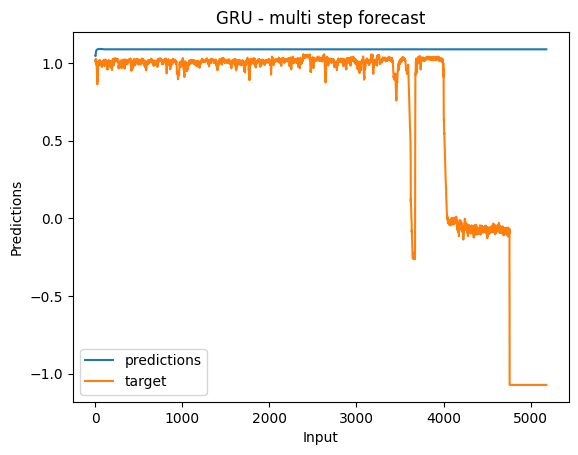

In [19]:
plt.plot(validation_predictions, label = 'predictions')
plt.plot(validation_targets, label = 'target')
plt.xlabel('Input')
plt.ylabel('Predictions')
plt.title('GRU - multi step forecast')
plt.legend()

In [107]:
data_scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10466 entries, 0 to 10465
Data columns (total 23 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Throttle (%)                            10466 non-null  float64
 1   Intake Temperature (C)                  10466 non-null  float64
 2   Barometric Pressure (kpa)               10466 non-null  float64
 3   Fuel Trim                               10466 non-null  float64
 4   Fuel Consumption (g/min)                10466 non-null  float64
 5   Fuel Consumed (g)                       10466 non-null  float64
 6   Expected BSFC (g/kW.hr)                 10466 non-null  float64
 7   Actual BSFC (g/kW.hr)                   10466 non-null  float64
 8   Expected Max Power (W)                  10466 non-null  float64
 9   Bus Voltage (V)                         10466 non-null  float64
 10  GCU Current (A)                         10466 non-null  fl

In [110]:
x_idx = [data_scaled_df.columns.get_loc(x) for x in data_scaled_df.columns[[0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 14, 16, 17, 18, 19, 21, 22]]]
T = 20
D = len(x_idx)
X = []
Y = []

for t in range(len(data_scaled) - T) :
    x = data_scaled[t : t + T, x_idx]
    X.append(x)
    
X = np.array(X).reshape(-1, T, D)
Y = np.array(Y)
N = len(X)
print(X.shape)


(10446, 20, 18)


In [111]:
i = Input(shape = (T, D))
x = LSTM(50, return_sequences=True) (i)
x = Dropout(0.2) (x)
x = LSTM(64, return_sequences=False) (x)
x = Dropout(0.2) (x)
x = Dense(T * D) (x)
x = Reshape((T, D)) (x)

model = Model(i, x)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 20, 18)]          0         
                                                                 
 lstm_6 (LSTM)               (None, 20, 50)            13800     
                                                                 
 dropout_6 (Dropout)         (None, 20, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                29440     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 360)               23400     
                                                                 
 reshape_1 (Reshape)         (None, 20, 18)            0   

In [112]:
model.compile(optimizer='adam', loss='mse')

history = model.fit(X, 
                    X, 
                    epochs=100, 
                    batch_size=64)

Epoch 1/100
164/164 [==============================] - 5s 12ms/step - loss: 0.3168
Epoch 2/100
164/164 [==============================] - 2s 11ms/step - loss: 0.1501
Epoch 3/100
164/164 [==============================] - 2s 10ms/step - loss: 0.1220
Epoch 4/100
164/164 [==============================] - 2s 12ms/step - loss: 0.1096
Epoch 5/100
164/164 [==============================] - 2s 13ms/step - loss: 0.1017
Epoch 6/100
164/164 [==============================] - 2s 14ms/step - loss: 0.0938
Epoch 7/100
164/164 [==============================] - 2s 15ms/step - loss: 0.0889
Epoch 8/100
164/164 [==============================] - 2s 13ms/step - loss: 0.0839
Epoch 9/100
164/164 [==============================] - 2s 13ms/step - loss: 0.0808
Epoch 10/100
164/164 [==============================] - 2s 12ms/step - loss: 0.0788
Epoch 11/100
164/164 [==============================] - 2s 12ms/step - loss: 0.0761
Epoch 12/100
164/164 [==============================] - 2s 13ms/step - loss: 0.0736
E

Text(0.5, 1.0, 'LSTM - Model Reconstruction Loss')

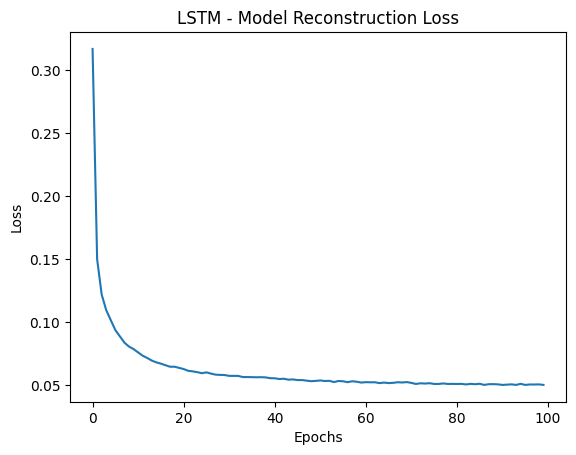

In [113]:
plt.plot(history.history['loss'], label = 'loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM - Model Reconstruction Loss')

In [114]:
train_predictions = model.predict(X, verbose= 0)
train_errors = np.mean(np.abs(train_predictions - X), axis=1)

In [115]:
# Calculate reconstruction error
reconstruction_errors = np.mean(np.abs(train_predictions - X), axis=(1, 2))

# Determine a threshold for outliers (e.g., 95th percentile of the training errors)
threshold = np.percentile(reconstruction_errors, 95)

# Identify outliers
outliers = reconstruction_errors > threshold

# Number of outliers detected
num_outliers = np.sum(outliers)
print(f"Number of outliers detected: {num_outliers}")


Number of outliers detected: 523


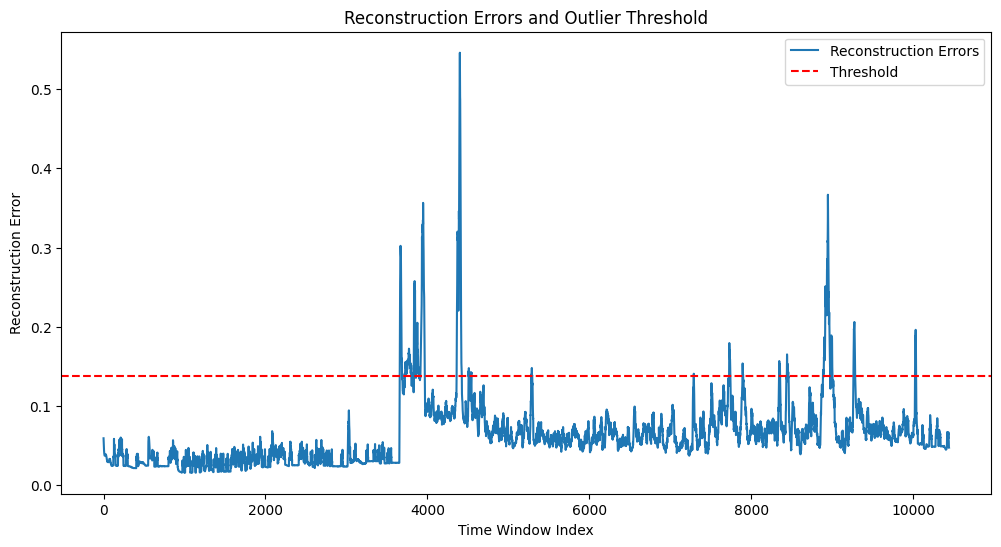

In [116]:
plt.figure(figsize=(12, 6))
plt.plot(reconstruction_errors, label='Reconstruction Errors')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Errors and Outlier Threshold')
plt.xlabel('Time Window Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()

In [117]:
outlier_flags = np.zeros(len(df), dtype=bool)

# Map the outliers back to the original DataFrame
for i in range(len(outliers)):
    if outliers[i]:
        # Mark all the entries in the sliding window as outlier
        outlier_flags[i : i + T // 2] = True

# Filter the DataFrame to get rows where outliers is True
df_outliers = df[outlier_flags]

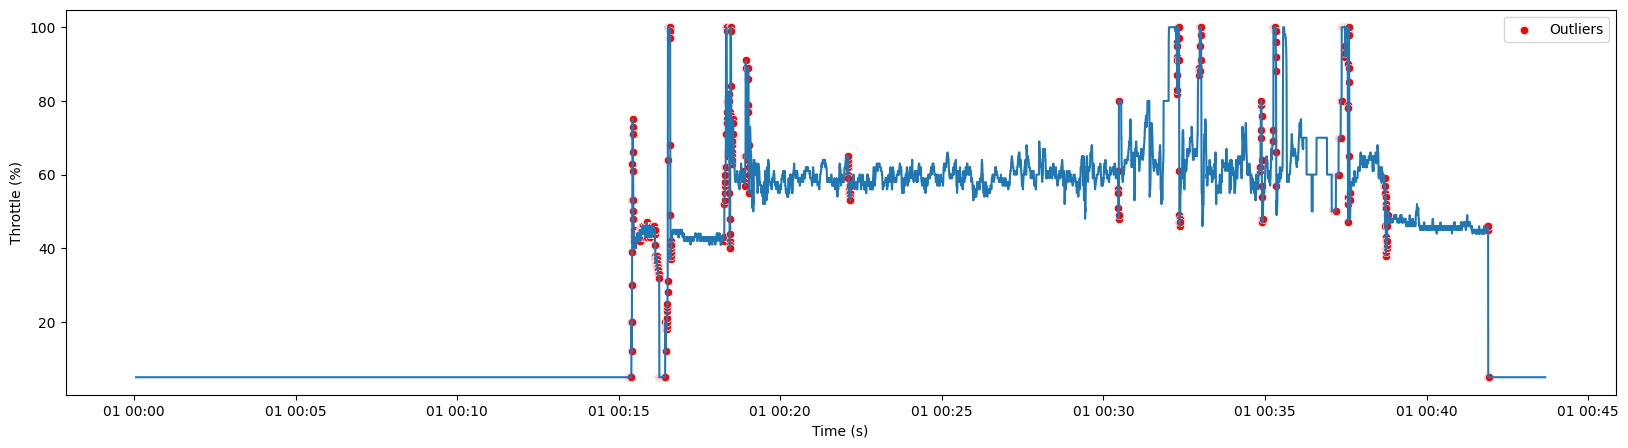

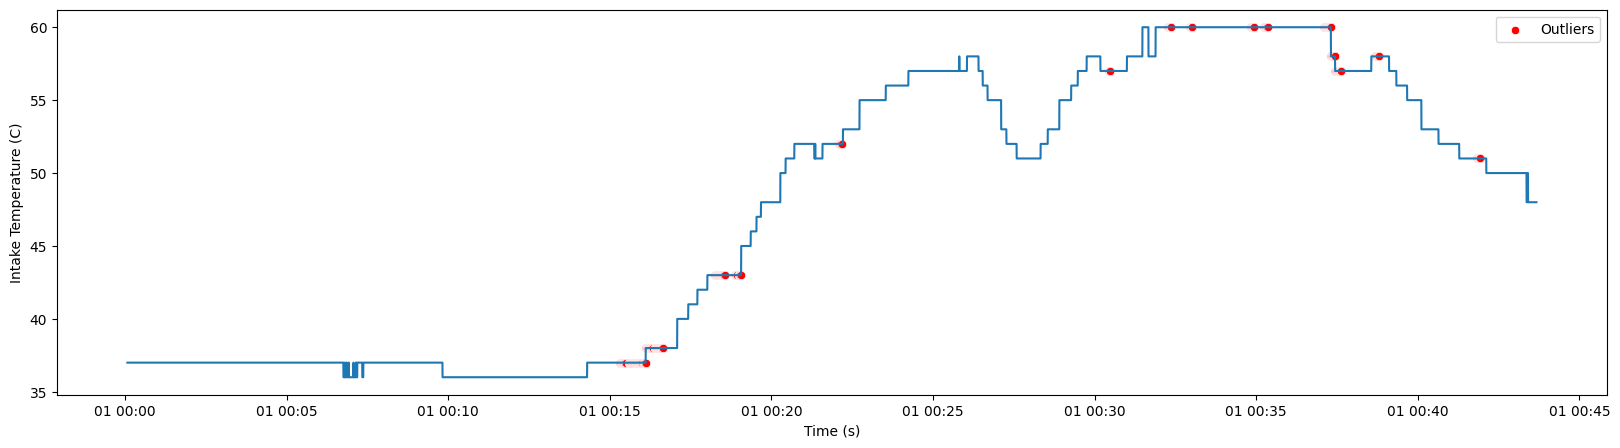

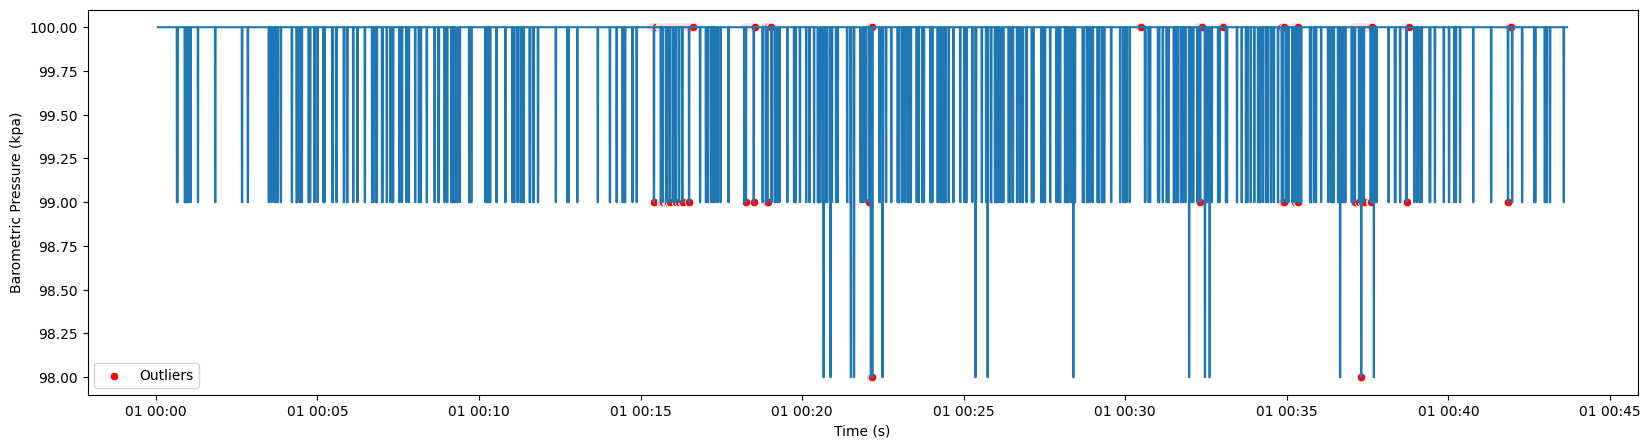

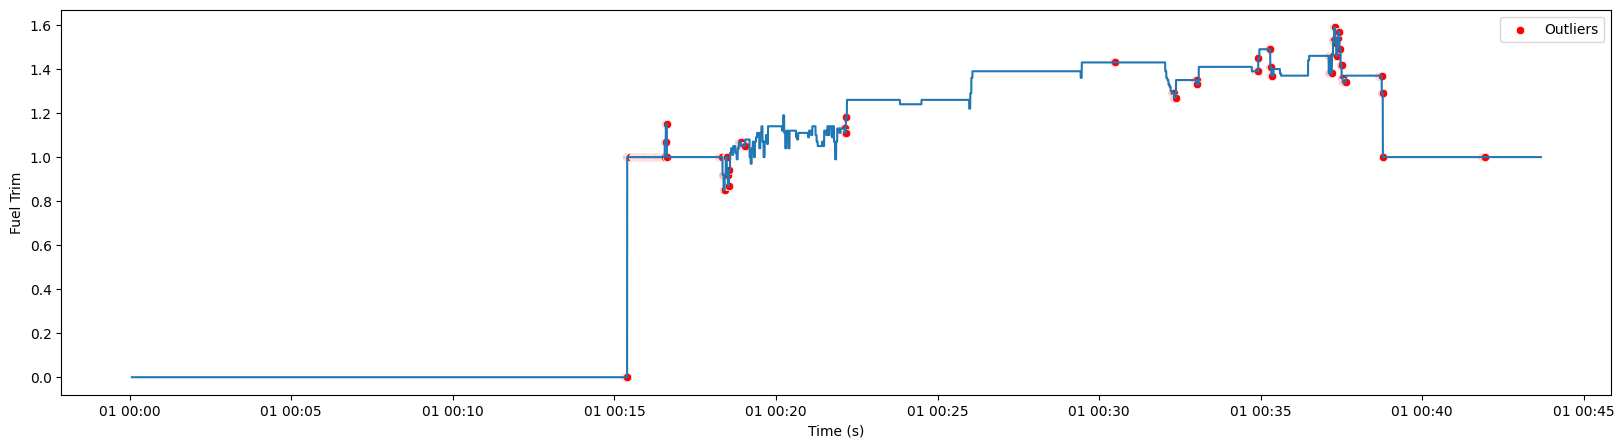

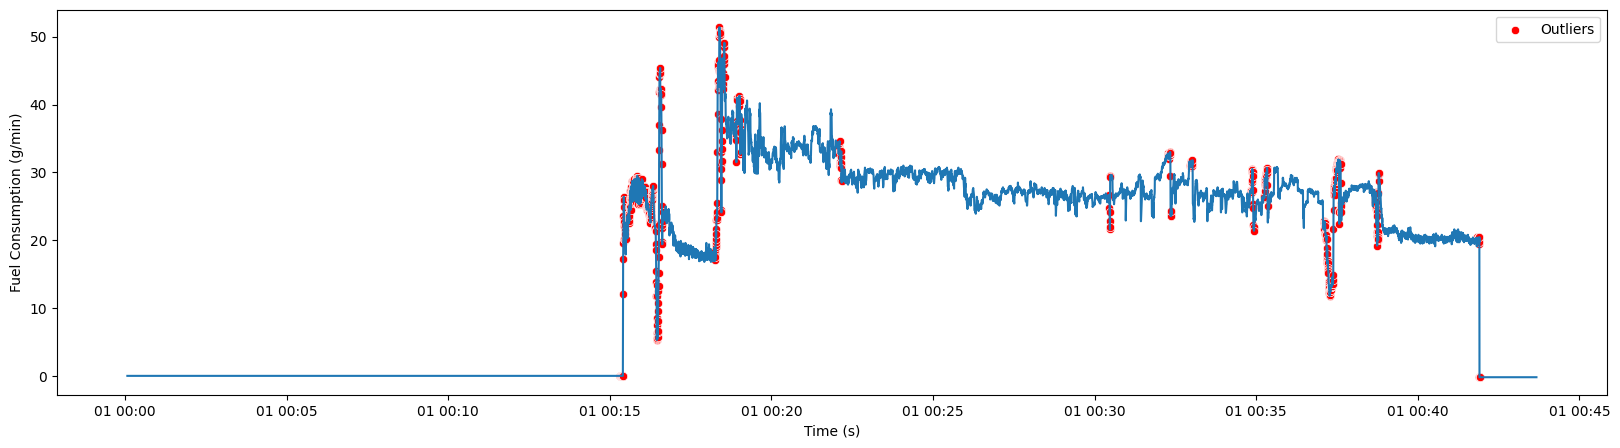

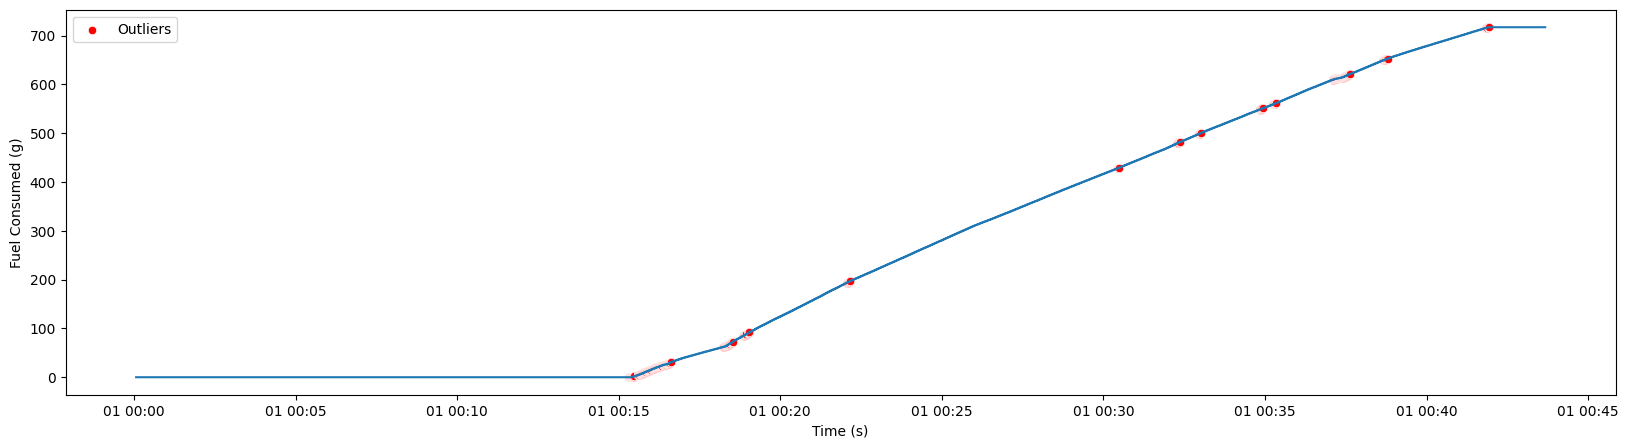

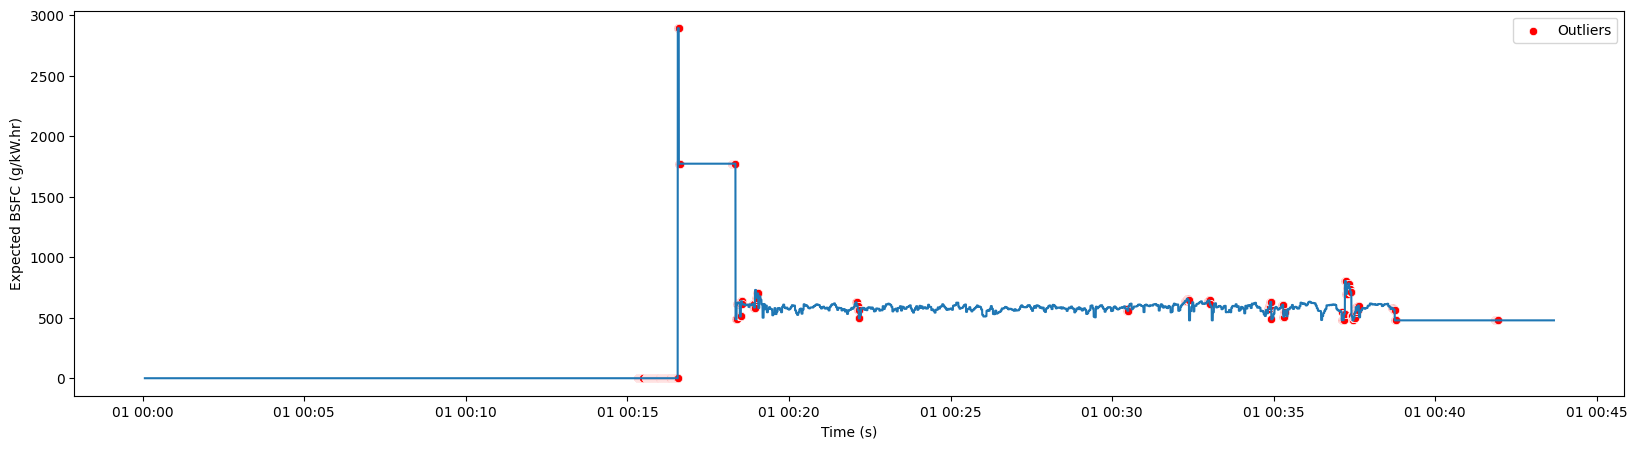

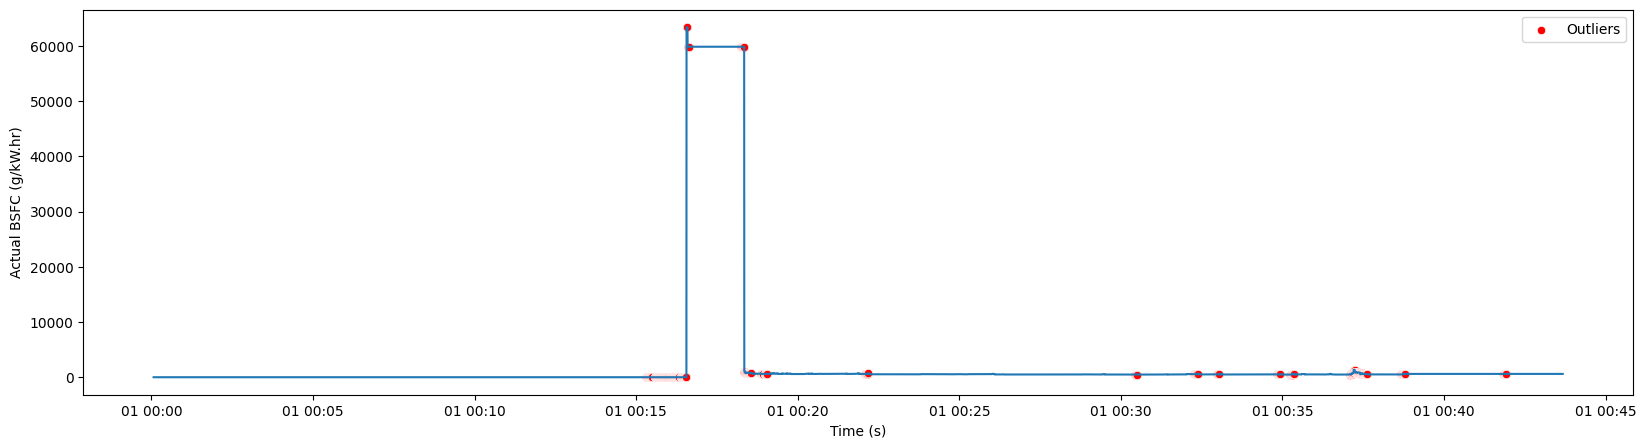

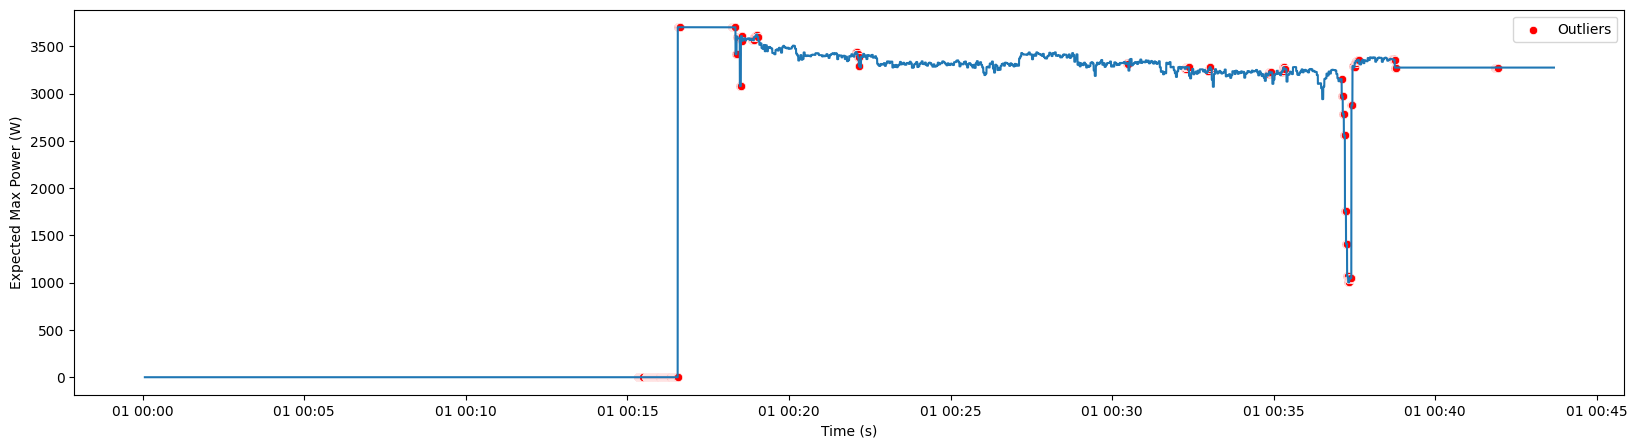

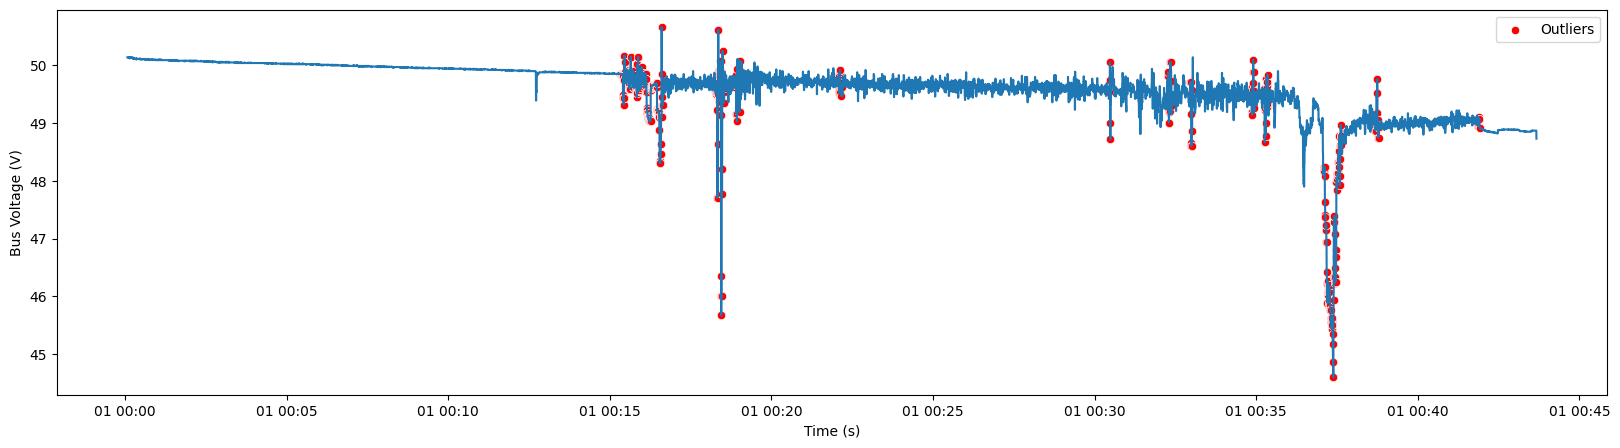

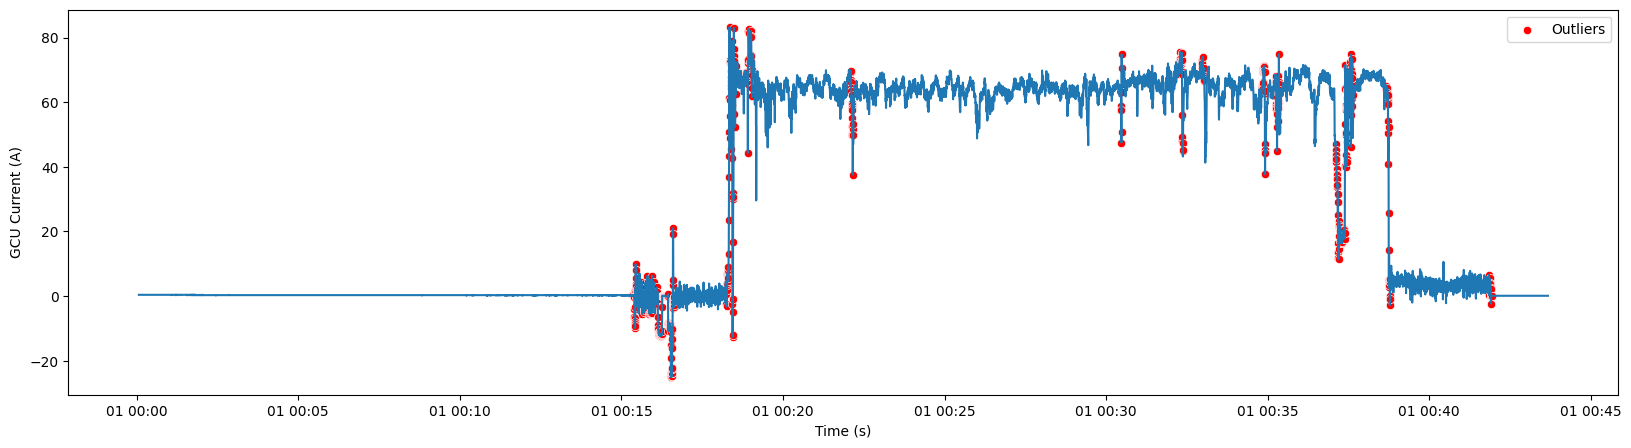

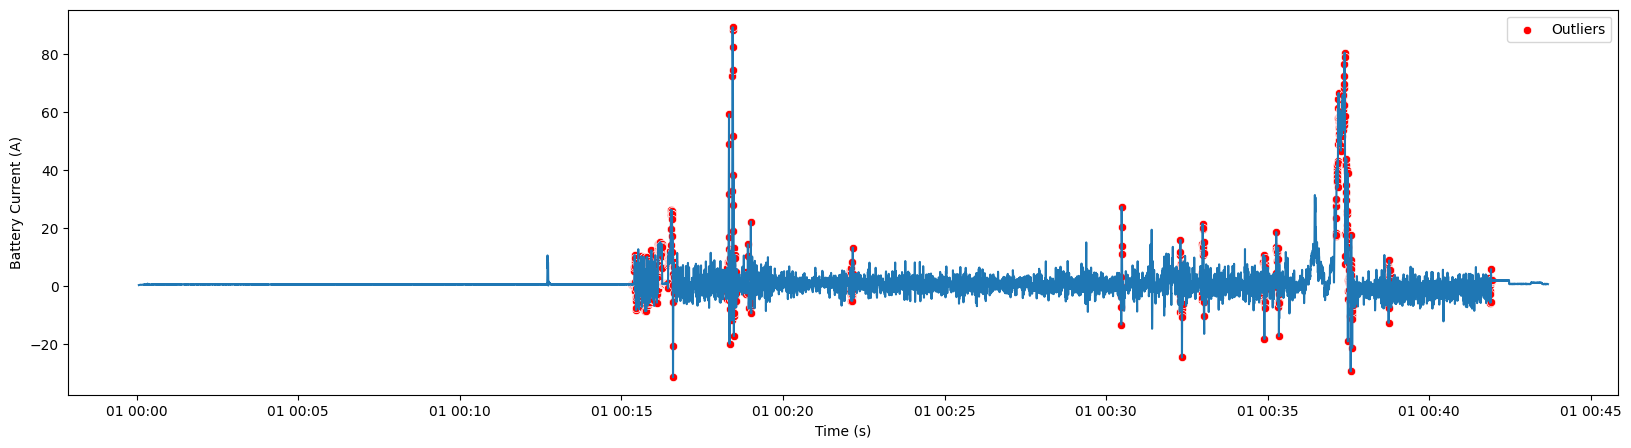

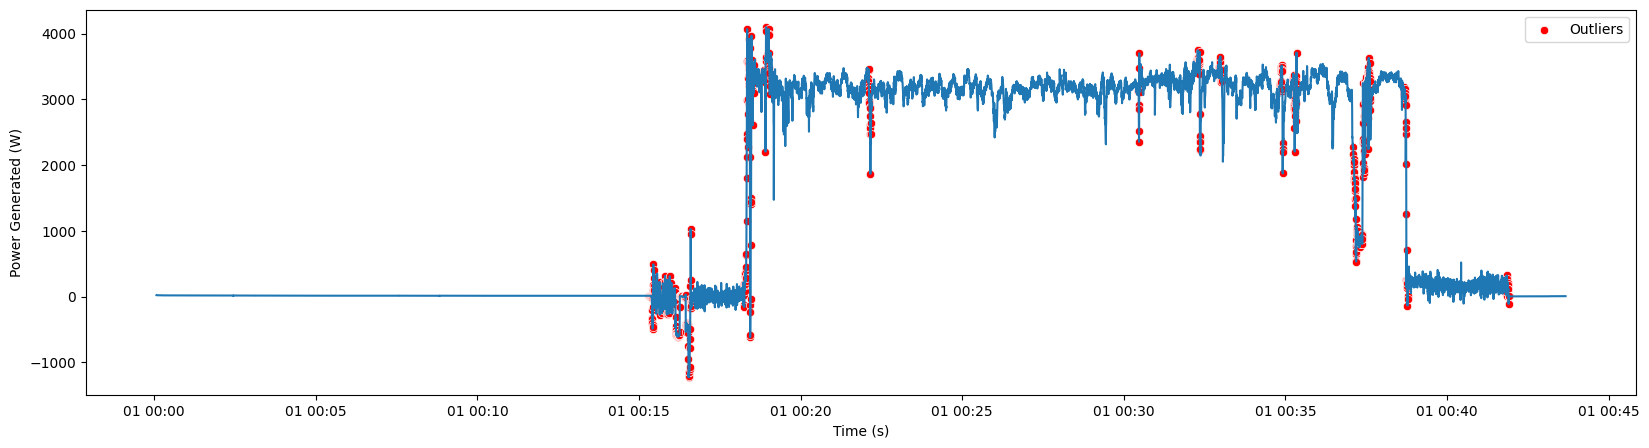

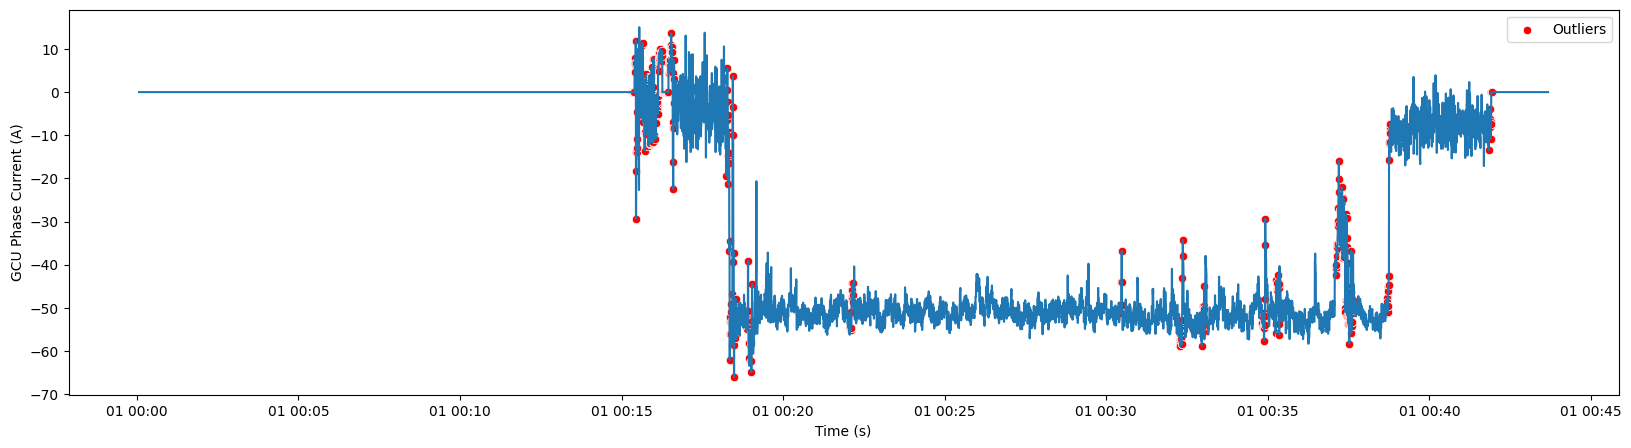

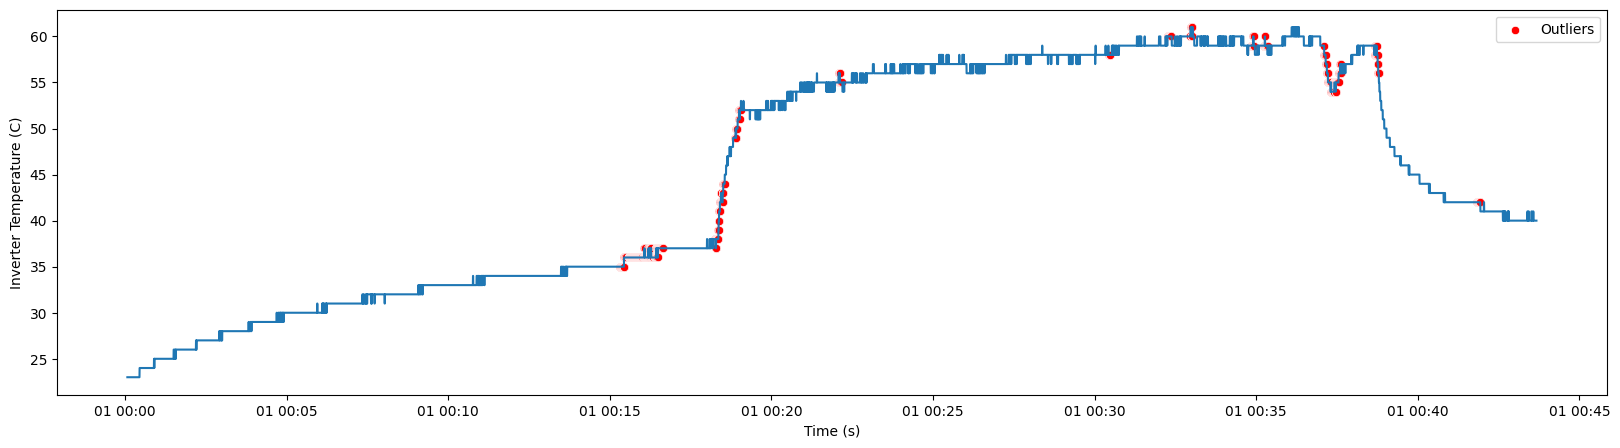

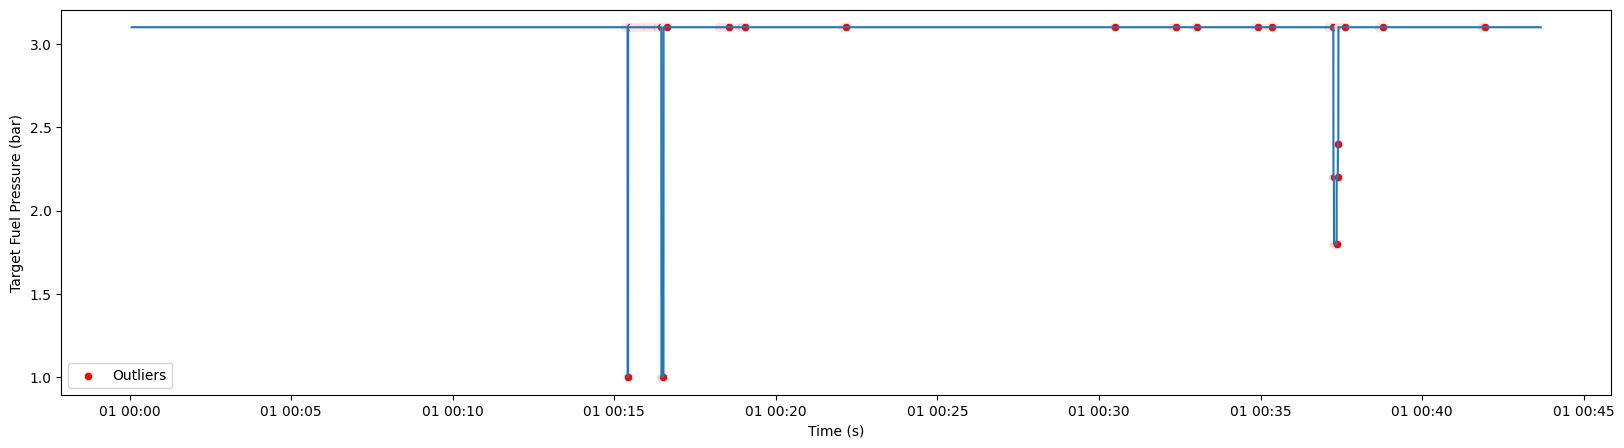

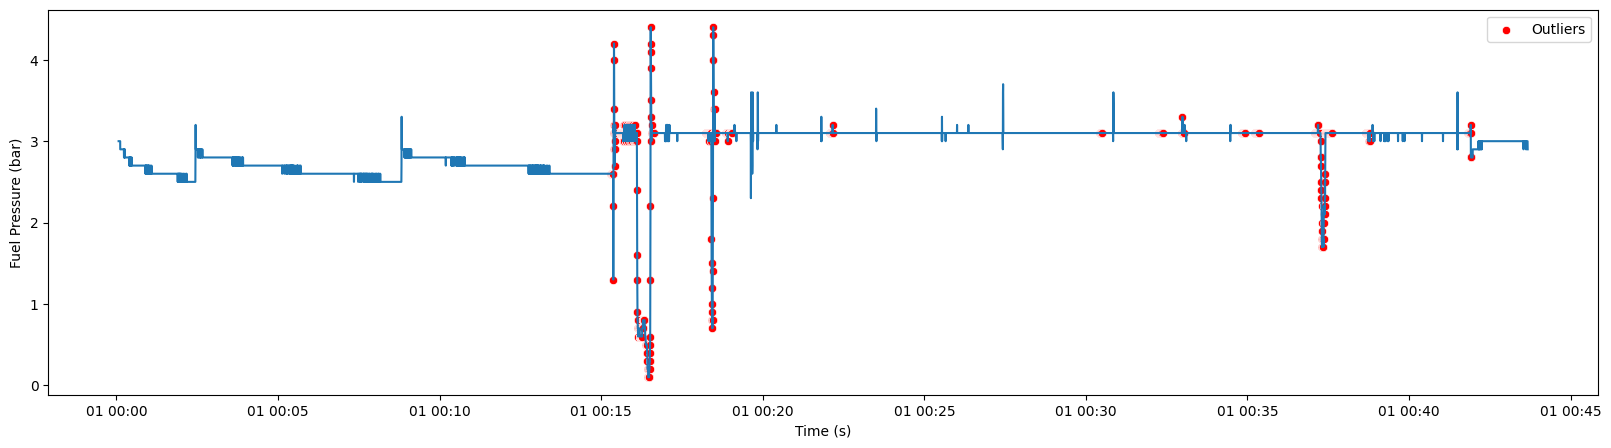

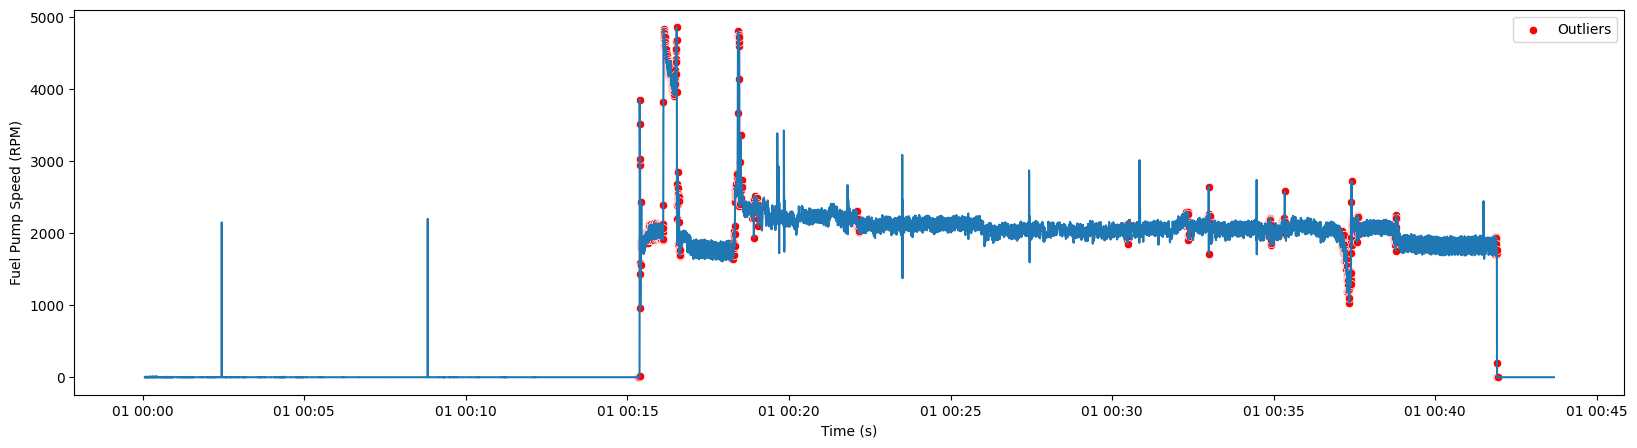

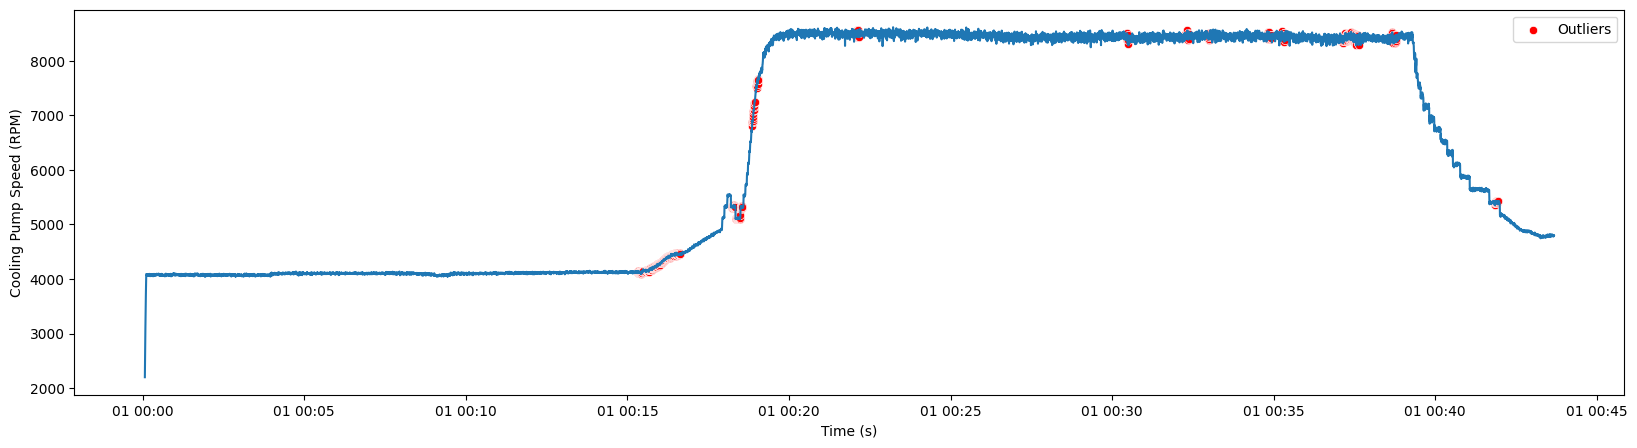

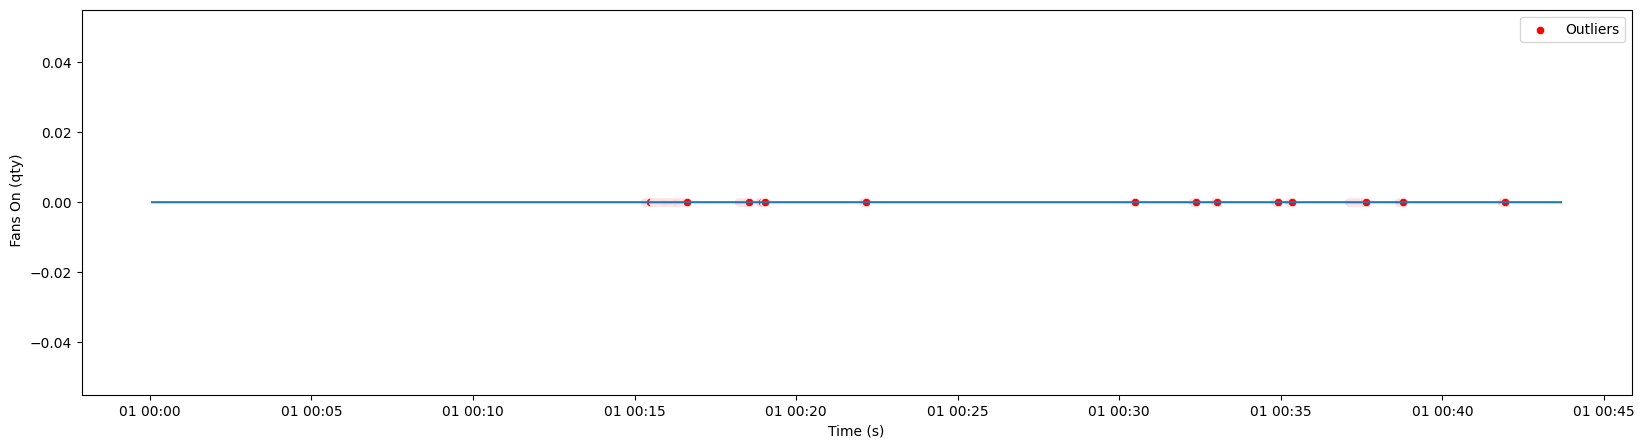

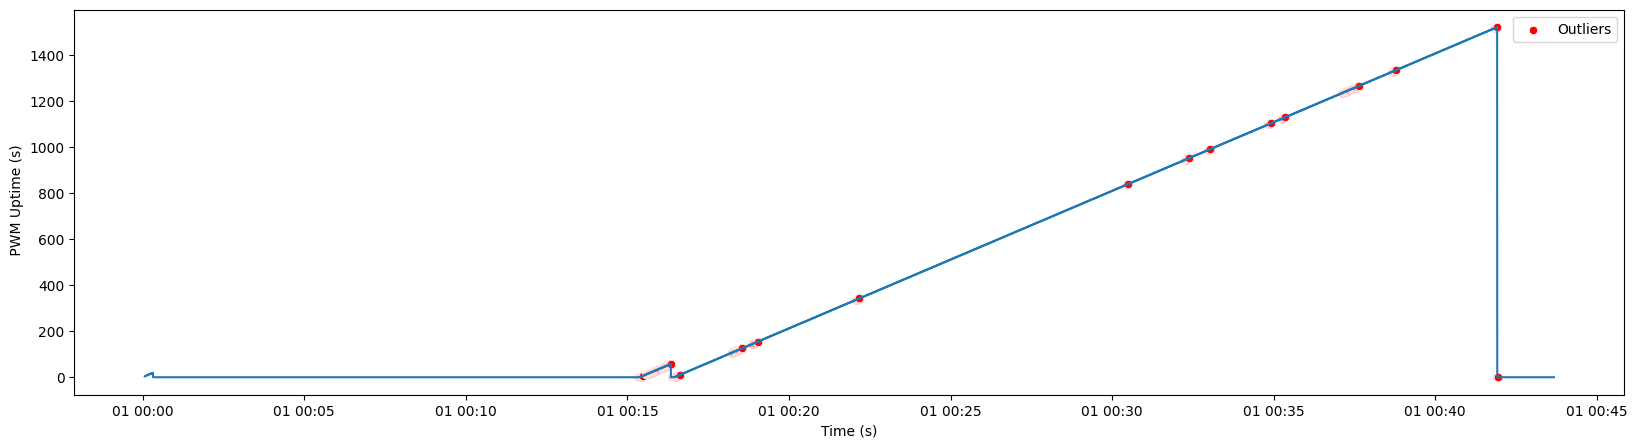

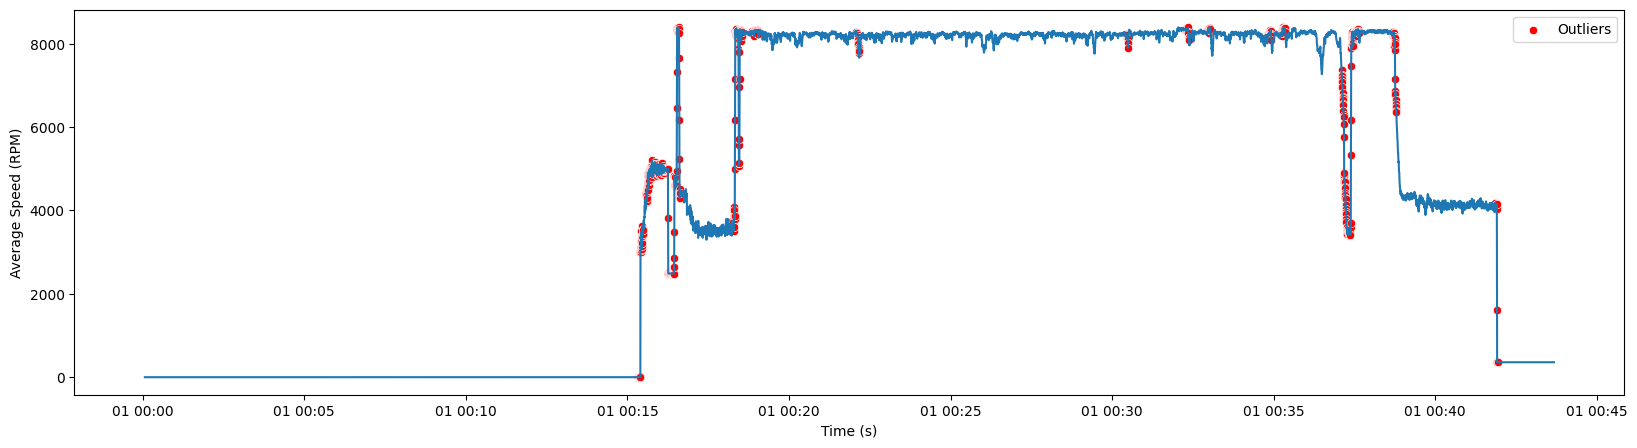

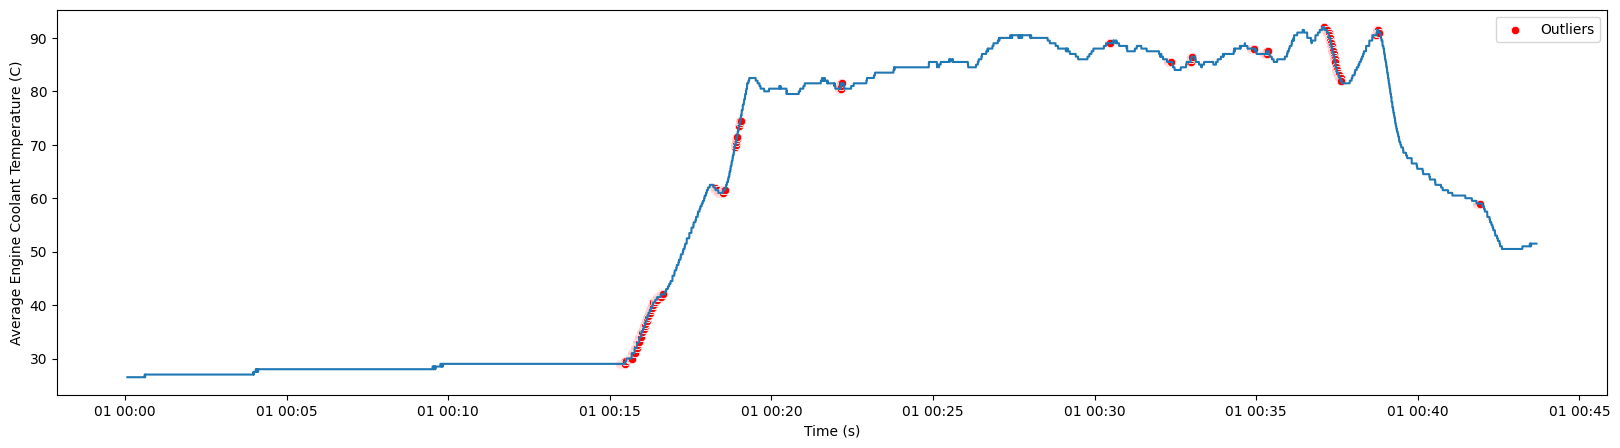

In [123]:
for col in data_scaled_df.columns :
    plot_x_y('Time (s)', col, df=df, outlier_df=df_outliers)

In [119]:
def expand_indices(indices, range_before=20, range_after=20, max_index=None):
    expanded_indices = set()
    for idx in indices:
        start_idx = max(0, idx - range_before)
        end_idx = min(max_index, idx + range_after + 1) if max_index is not None else idx + range_after + 1
        expanded_indices.update(range(start_idx, end_idx))
    return sorted(expanded_indices)

max_index = len(df) - 1

In [120]:
df_outliers[0: 0+T].index

Index([3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671,
       3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679],
      dtype='int64')

In [121]:
expanded_indices = expand_indices(df_outliers[0: 0+T].index, 10, 10, max_index)

In [122]:
df.iloc[expanded_indices, :]

Time (s)  Throttle (%)  Intake Temperature (C)  \
3650 1970-01-01 00:15:16.540             5                      37   
3651 1970-01-01 00:15:16.790             5                      37   
3652 1970-01-01 00:15:17.040             5                      37   
3653 1970-01-01 00:15:17.290             5                      37   
3654 1970-01-01 00:15:17.540             5                      37   
3655 1970-01-01 00:15:17.790             5                      37   
3656 1970-01-01 00:15:18.040             5                      37   
3657 1970-01-01 00:15:18.290             5                      37   
3658 1970-01-01 00:15:18.540             5                      37   
3659 1970-01-01 00:15:18.790             5                      37   
3660 1970-01-01 00:15:19.040             5                      37   
3661 1970-01-01 00:15:19.290             5                      37   
3662 1970-01-01 00:15:19.540             5                      37   
3663 1970-01-01 00:15:19.790             5                      37   
3664 1970-01-01 00:15:20.040             5                      37   
3665 1970-01-01 00:15:20.290             5                      37   
3666 1970-01-01 00:15:20.540             5                      37   
3667 1970-01-01 00:15:20.790             5                      37   
3668 1970-01-01 00:15:21.040             5                      37   
3669 1970-01-01 00:15:21.290             5                      37   
3670 1970-01-01 00:15:21.540             5                      37   
3671 1970-01-01 00:15:21.790             5                      37   
3672 1970-01-01 00:15:22.040             5                      37   
3673 1970-01-01 00:15:22.290             5                      37   
3674 1970-01-01 00:15:22.540             5                      37   
3675 1970-01-01 00:15:22.790             5                      37   
3676 1970-01-01 00:15:23.040             5                      37   
3677 1970-01-01 00:15:23.290             5                      37   
3678 1970-01-01 00:15:23.540             5                      37   
3679 1970-01-01 00:15:23.790            20                      37   
3680 1970-01-01 00:15:24.040            20                      37   
3681 1970-01-01 00:15:24.290            12                      37   
3682 1970-01-01 00:15:24.540            20                      37   
3683 1970-01-01 00:15:24.790            30                      37   
3684 1970-01-01 00:15:25.040            39                      37   
3685 1970-01-01 00:15:25.290            53                      37   
3686 1970-01-01 00:15:25.540            63                      37   
3687 1970-01-01 00:15:25.790            73                      37   
3688 1970-01-01 00:15:26.040            75                      37   
3689 1970-01-01 00:15:26.290            71                      37   

      Barometric Pressure (kpa)  Fuel Trim  Fuel Consumption (g/min)  \
3650                        100        0.0                       0.0   
3651                        100        0.0                       0.0   
3652                        100        0.0                       0.0   
3653                        100        0.0                       0.0   
3654                        100        0.0                       0.0   
3655                        100        0.0                       0.0   
3656                        100        0.0                       0.0   
3657                        100        0.0                       0.0   
3658                        100        0.0                       0.0   
3659                        100        0.0                       0.0   
3660                        100        0.0                       0.0   
3661                        100        0.0                       0.0   
3662                        100        0.0                       0.0   
3663                        100        0.0                       0.0   
3664                        100        0.0                       0.0 

In [ ]:
## Multioutput regressor without temporal data

In [ ]:
## multioutput regressor with temporal + lagged data